In [1]:
# this file is for running the line-fitting models and plot the best-fitting results 
import numpy as np
from astropy.io import fits
import os, sys
# from veremisfitting.line_fitting_exec import *
# from veremisfitting.line_fitting_model import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models,fitting
import astropy.units as u
import astropy.constants as const

%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep
import glob
import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

from astropy.table import Table
import astropy.units as u

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 

from msafit.fpa import PSFLib
import numpy as np
from msafit.model import Sersic
from msafit.fpa import Spec2D
from msafit.lsf import LSF
from copy import deepcopy
from msafit.model.config import get_default_config
import os

os.environ['msa_refdata'] = '/Users/zijianzhang/Documents/code/JWST_learning/NIRSpec/LSF_files/'
params = get_default_config()

shuterdict = {
    '1x1': '1x3',
    'x11': '1x3',
    '11x': '1x3',
    '1x11': '1x3',
    '11x1': '1x3',
    'x': '1x1'
}

def lsf_resolution(sp, wavelength):
    SHUTSTA = sp.meta['SHUTSTA']
    disire_psf_file = shuterdict[SHUTSTA] + '_' + sp.meta['GRATING'] + '_Q3_PSFLib.fits'
    print(disire_psf_file)

    params['instrument']['filter'] = sp.meta['FILTER']
    params['instrument']['disperser'] = sp.meta['GRATING']
    # SHUTSTA = sp.meta['SHUTSTA']

    psfs = PSFLib(disire_psf_file)

    params["grid"]["x_grid"] = psfs.psf_x
    params["grid"]["y_grid"] = psfs.psf_y
    params["grid"]["wave_grid"] = psfs.psf_wave

    params["morph"][0]["profile"] = "sersic"  # specify the profile
    params["morph"][0]["flux"] = 1.           # integrated flux of the Sersic profile
    params["morph"][0]["x0"] = 0            # offset in dispersion direction (pitch, not arcsec)
    params["morph"][0]["y0"] = 0.0           # offset in cross-dispersion direction (pitch, not arcsec)
    params["morph"][0]["r_e"] = 0.03           # this is in arcsec
    params["morph"][0]["n"] = 4             # Sersic index
    params["morph"][0]["q"] = 1             # axis ratio
    params["morph"][0]["PA"] = 90             # rotation angle wrt positive x-axis 
                                              # (note: differs from e.g. the galfit default)

    # create a model cube I(x,y,lambda)
    model = Sersic(params)
    model(params["grid"]["wave_grid"])
    # print(model.data.shape)


    spec = Spec2D(params)
    throughput = spec.make_spec2d(model,psfs,return_fluxes=True)

    params_2 = deepcopy(params)
    params_2["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] - 1
    params_2["geometry"]["source_shutter"] = -1
    spec_2 = Spec2D(params_2)
    spec_2.make_spec2d(model,psfs)

    params_3 = deepcopy(params)
    params_3["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] + 1
    params_3["geometry"]["source_shutter"] = 1
    spec_3 = Spec2D(params_3)
    spec_3.make_spec2d(model,psfs)


    # we provide our 3 nods to the LSF class
    # we only provide the wavelengths of interest (wl_fpa) and corresponding detector (x_fpa) coordinates once
    lsf = LSF([spec,spec_2,spec_3],spec.wl_fpa,spec.x_fpa)
    # lsf = LSF([spec],spec.wl_fpa,spec.x_fpa)
    fit_output = lsf.compute_lsf()
    # fit_output
    # print('resolution at 2.52 micron =', lsf.resolution(3.52e4))
    # print('dispersion at 1.78 micron =', lsf.dispersion_kms(3.78e4), 'km/s')
    return float(lsf.dispersion_kms(wavelength))#, lsf.resolution(wavelength)




grizli version: 1.12.9
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
msaexp version: 0.9.2


In [2]:
nrs = Table.read('/Users/zijianzhang/Documents/code/JWST_learning/NIRSpec/DJA_NIRSpec.csv')
# selectedlrd_cat = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/LRD_selection/all_nirspechighz_LRD_z2.ecsv')
# selectedlrd_cat = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/LRD_selection/all_nirspec_beta_withclassify_z2.ecsv')
selectedlrd_cat = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf_z2/LRD_spectral_catalog.csv')

jade_gal = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/jades_galaxies_sfr_withspecphot_DJA.csv')
# nrs = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/UDS_lrd_catalog.txt', format='ascii')
# nrs = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/all_lrd_catalog.txt', format='ascii')


savetop_ = '/Users/zijianzhang/Documents/JWST_learning/NIRSpec/LRD/'
spec_dir = current_direc + '/example_inputs/'
os.makedirs(savetop_, exist_ok=True) 
Grating = np.array([i.split('_')[1] for i in nrs['file']])

# id = '58975' # remarkable z=9
# ymax = [1, 0.2, 0.7, 0.7]
# xlimits = [(0.5, 5.4), (0.5, 2.2), (3.9, 4.6), (5.0, 5.3)]

# id = '35180' # bright z=1.8
# ymax = [2]*4
srcid_set = np.unique(nrs['srcid'])
lrd_uid_set = np.unique(selectedlrd_cat['source_id'])
jade_gal_uid = np.unique(jade_gal['uid'])

srcid = nrs['srcid']
uid = nrs['uid']
id = '40579' # z=4.1
ymax = [0.8, 0.4, 0.8, 0.8]
xlimits = [(0.5, 5.4), (0.5, 2.2), (2.2, 2.8), (3.18, 3.6)]


In [3]:
from scipy.integrate import simps
import numpy as np
from astropy.modeling import models, fitting
from astropy.constants import c
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import lmfit
from lmfit.models import GaussianModel, ConstantModel
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.constants as spy_const  # 光速 (m/s)
from lmfit import minimize

cosmo = FlatLambdaCDM(H0=69.6 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.286)


def convolve_with_lsf(model_flux, v_axis, sigma_lsf):
    """
    使用 astropy 进行 LSF 卷积
    :param model_flux: 原始模型光谱（在速度空间）
    :param v_axis: 速度轴
    :param lsf: LSF 对象，提供 resolution(wrange)
    :param wrange: 对应的波长范围
    :return: 经过 LSF 卷积的模型光谱
    """
    # 计算 LSF 贡献的标准差 (km/s)
    # R = lsf.resolution(wrange)  # LSF 分辨率
    # sigma_lsf = (spy_const.c / 1000) / (R * np.sqrt(8 * np.log(2)))  # c 换算成 km/s
    

    # 计算 LSF 核的宽度 (转换到速度空间的点数)
    dv = np.mean(np.diff(v_axis))  # 速度步长 (km/s)
    sigma_pixels = np.max(sigma_lsf) / dv  # 在速度轴上的 sigma

    # 生成高斯核
    gaussian_kernel = Gaussian1DKernel(stddev=sigma_pixels)

    # 进行 LSF 卷积
    convolved_flux = convolve(model_flux, gaussian_kernel, boundary='extend')

    return convolved_flux


class EmissionLineFitter:
    def __init__(self, sp, z, reference_wavelength, fit_line_id=None):
        self.sp = sp
        self.z = z
        self.reference_wavelength = reference_wavelength
        self.obs_wavelength = reference_wavelength * (1 + z)
        self.fit_line_id = fit_line_id
        self.gaussians = []
        self.component_results = {}
        self.auto_bounds = False
        self.max_flux = None
        self._prepare_data()
        self.lm_model = None
        self.lm_params = lmfit.Parameters()
        self.fit_result = None

    def _prepare_data(self):
        mask = self.sp.valid > 0
        self.w_obs = self.sp.spec_wobs[mask] / (1 + self.z) * 10000
        self.flux = self.sp.spec['flux'][mask] * self.sp.spec['to_flam'][mask] * (1 + self.z) #* 1e-20
        self.flux_err = self.sp.spec['err'][mask] * self.sp.spec['to_flam'][mask] * (1 + self.z) #* 1e-20
        self.max_flux = np.max(self.flux)
        self.v_obs = (self.w_obs - self.reference_wavelength) / self.reference_wavelength * c.to('km/s').value

    def slice_region(self, velocity_range):
        idx = np.where((self.v_obs >= -velocity_range) & (self.v_obs <= velocity_range))
        self.w_sliced = self.w_obs[idx] * 10000
        self.flux_sliced = self.flux[idx]
        self.flux_err_sliced = self.flux_err[idx]
        self.v_sliced = self.v_obs[idx]

    def set_gaussian_components(self, num_components, initial_params):
        self.lm_params = lmfit.Parameters()
        # Continuum component
        self.lm_params.add('cont_c', value=np.median(self.flux_sliced), min=0)
        
        # Gaussian components
        self.gaussians = []
        sigma_names = {}  # 存储每个高斯的 sigma 参数名
        center_names = {}  # 存储每个高斯的 center 参数名
        for i in range(num_components):
            prefix = f'g{i}_'
            params = initial_params[i]
            # print(params.get('amp_bounds', (0, None))[0], params.get('amp_bounds', (0, None))[1])
            self.lm_params.add(f'{prefix}amplitude', value=params['amplitude'], 
                              min=params.get('amp_bounds', (0, None))[0],
                              max=np.inf)
                            #    min=0,
                            #   max=1, vary=True)
            # self.lm_params.add(f'{prefix}center', value=params['mean'],
            #                   min=params.get('mean_bounds', (-np.inf, np.inf))[0],
            #                   max=params.get('mean_bounds', (-np.inf, np.inf))[1])
            # self.lm_params.add(f'{prefix}sigma', value=params['stddev'],
            #                   min=params.get('std_bounds',  (0, None))[0],
            #                   max=params.get('std_bounds',  (0, None))[1])
            # 处理 sigma 绑定
            sigma_name = f'{prefix}sigma'
            tied_sigma = params.get('tied_sigma', None)
            tied_center = params.get('tied_center', None)
            tied_center_value = params.get('tied_center_value', None)
        

            if tied_sigma is not None:  # 绑定 sigma
                tied_sigma_name = sigma_names.get(tied_sigma)
                if tied_sigma_name:
                    self.lm_params.add(sigma_name, expr=tied_sigma_name)  # 绑定到已有 sigma
                else:
                    raise ValueError(f"Invalid tied_sigma index {tied_sigma} for Gaussian {i}")
            else:  # 独立 sigma
                self.lm_params.add(sigma_name, value=params['stddev'],
                                   min=params.get('std_bounds', (0, None))[0],
                                   max=params.get('std_bounds', (0, None))[1])
                sigma_names[i] = sigma_name  # 记录 sigma 名字，以便绑定

            
            if 'center_diff_range' in params:  # 检查是否有差距约束
                diff_range = params['center_diff_range']
                if len(diff_range) == 2:
                    lower, upper = diff_range
                    delta_initial = (upper + lower) / 2  # 初始差距
                    # 为 center 设置差距约束：确保其差距在给定范围内
                    if i > 0:  # 只有在 i > 0 时，才与其他高斯建立差距约束
                        # expr = f"abs(g{i}_center - g0_center) >= {lower} & abs(g{i}_center - g0_center) <= {upper}"
                        self.lm_params.add(f'delta{i}', value=delta_initial, min = lower, max=upper, vary=True)
                        self.lm_params.add(f'{prefix}center', value=params['mean'],
                              min=params.get('mean_bounds', (-np.inf, np.inf))[0],
                              max=params.get('mean_bounds', (-np.inf, np.inf))[1], expr  = f'g0_center + delta{i}')
            elif tied_center is not None:  # 绑定 center
                tied_center_name = center_names.get(tied_center)
                if tied_center_name:
                    if(tied_center_value > 0):
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name  +  f' + {tied_center_value}')
                    elif(tied_center_value < 0):
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name  +  f' - {-tied_center_value}')
                    else:
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name)
                else:
                    raise ValueError(f"Invalid tied_center index {tied_center} for Gaussian {i}")
            else:  # 独立 center
                self.lm_params.add(f'{prefix}center', value=params['mean'],
                              min=params.get('mean_bounds', (-np.inf, np.inf))[0],
                              max=params.get('mean_bounds', (-np.inf, np.inf))[1])
                center_names[i] = f'{prefix}center'  # 记录 center 名字，以便绑定
             #处理中心差距约束

            self.gaussians.append(GaussianModel(prefix=prefix))

        # Build composite model
        self.lm_model = ConstantModel(prefix='cont_')
        for g in self.gaussians:
            self.lm_model += g

      

    def fit_emission_line(self, use_monte_carlo=True):
        # First fit continuum+gaussians
        
        # ----------------------
        # def residuals(params, x, y, y_err, sigma_lsf):
        #     """计算 (数据 - LSF修正后的模型) / 误差"""
        #     model_flux = self.lm_model.eval(params, x=x)  # 计算原始模型
        #     model_flux_lsf = convolve_with_lsf(model_flux, x, sigma_lsf)  # 进行 LSF 卷积
        #     return (y - model_flux_lsf) / y_err  # 计算归一化残差

        # # 使用 lmfit 的 minimize 进行拟合
        # self.fit_result = minimize(
        #     residuals, self.lm_params, args=(self.v_sliced, self.flux_sliced, 
        #                                      self.flux_err_sliced, self.sigma_lsf)
        # )
        # ----------------------
        self.fit_result = self.lm_model.fit(self.flux_sliced, self.lm_params, x=self.v_sliced, weights=1/self.flux_err_sliced, method='least_squares')  # 计算协方差

        
        # Subtract continuum
        self.cont_value = self.fit_result.params['cont_c'].value
        self.flux_sliced_contsub = self.flux_sliced - self.cont_value
        
        # # Fit gaussians to continuum-subtracted data
        # gauss_model = reduce(add, [g for g in self.gaussians])
        # gauss_params = result.params.copy()
        # gauss_params.pop('cont_c')  # Remove continuum parameter
        
        # self.fit_result = gauss_model.fit(self.flux_sliced_contsub, gauss_params, 
        #                                  x=self.v_sliced, weights=1/self.flux_err_sliced)
        
        # Calculate statistics
        model_flux = self.cont_value + self.fit_result.best_fit
        residuals = self.flux_sliced - model_flux
        
        # model_flux = self.lm_model.eval(self.fit_result.params, x=self.v_sliced)
        # model_flux_lsf = convolve_with_lsf(model_flux, self.v_sliced, self.sigma_lsf)
        # residuals = self.flux_sliced - model_flux_lsf
        
        # self.chi2 = np.sum((residuals / self.flux_err_sliced) ** 2)
        # self.reduced_chi2 = self.chi2 / (len(residuals) - len(self.fit_result.params))
        self.chi2 = self.fit_result.chisqr
        self.reduced_chi2 = self.fit_result.redchi
        self.BIC = self.fit_result.bic
        self.AIC = self.fit_result.aic
        
        # Handle parameter errors
        if self.fit_result.errorbars and not use_monte_carlo:
            self.parameter_errors = np.array([self.fit_result.params[p].stderr 
                                             for p in self.fit_result.var_names])
        # else:
        #     self.estimate_errors_monte_carlo()
        
        return self.fit_result, self.chi2, self.reduced_chi2

    def calculate_flux_ew_fwhm(self,  guass_or_lorentz='gauss'):
        sigma_lsf = lsf_resolution(sp, self.obs_wavelength)
        self.sigma_lsf = sigma_lsf

        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        wave_high_res = x_high_res * self.reference_wavelength / c.to('km/s').value + self.reference_wavelength
        # cont_flux = self.fitted_cont(x_high_res)
        cont_flux = self.cont_value * np.ones_like(x_high_res)

        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            params = self.fit_result.params
            amp = params[f'{prefix}amplitude'].value
            amp_err = params[f'{prefix}amplitude'].stderr or 0
            width_v = params[f'{prefix}sigma'].value
            width_v_err = params[f'{prefix}sigma'].stderr or 0
            de_convoved_width = np.sqrt(width_v**2 - self.sigma_lsf**2)
            de_convoved_width_err = np.sqrt((width_v_err/width_v)**2 + (sigma_lsf/width_v)**2) * de_convoved_width
            # params[f'{prefix}de_convoved_width'] = de_convoved_width
            # params[f'{prefix}de_convoved_width_err'] = de_convoved_width_err

            peak = 0.3989423*amp / (width_v)
            peak_err = peak * np.sqrt((amp_err/amp)**2 + (width_v_err/width_v)**2)
            width_AA = width_v * self.reference_wavelength / const.c.to('km/s').value
            width_err_AA = width_v_err * self.reference_wavelength / const.c.to('km/s').value

            # Calculate flux and flux error
            flux = peak * width_AA * np.sqrt(2 * np.pi)
            # print(np.sqrt((peak_err / peak) ** 2 + (width_err / width) ** 2))
            flux_err = flux * np.sqrt((peak_err / peak) ** 2 + (width_err_AA / width_AA) ** 2) if peak != 0 and width_AA != 0 else 0.0
    
            # calculate luminosity
            lumdis = cosmo.luminosity_distance(self.z)
            luminosity = flux * 4 * np.pi * lumdis.to('cm').value ** 2
            luminosity_err = flux_err * 4 * np.pi * lumdis.to('cm').value ** 2

            # Calculate EW and EW error
            # model_flux = gaussian(x_high_res)
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            r_i_all = (-model_flux) / cont_flux
            ew_all = np.abs(simps(r_i_all, wave_high_res))
    
            delta_x_median = np.median(np.diff(wave_high_res))
            epsilon_all = np.sqrt(np.sum((r_i_all - np.mean(r_i_all)) ** 2) / len(r_i_all))
            if guass_or_lorentz == 'gauss':
                ew_all_err = 2.45 * np.sqrt(width_AA * delta_x_median) * epsilon_all
            elif guass_or_lorentz == 'lorentz':
                ew_all_err = 2.74 * np.sqrt(width_AA * delta_x_median) * epsilon_all
            else:
                raise ValueError("Invalid profile type. Choose 'gauss' or 'lorentz'.")
    
            # Calculate FWHM and FWHM error
            fwhm = 2.35482 * np.abs(width_v)
            fwhm_err = 2.35482 * width_v_err
            de_convoved_fwhm = 2.35482 * de_convoved_width
            de_convoved_fwhm_err = 2.35482 * de_convoved_width_err
    
            # Store results
            self.component_results[f"Gaussian {i + 1}"] = {
                "Flux": flux*1e-20,
                "Flux_Error": flux_err*1e-20,
                "Luminosity": luminosity*1e-20,
                "Luminosity_Error": luminosity_err*1e-20,
                "EW": ew_all,
                "EW_Error": ew_all_err,
                "FWHM": fwhm,
                "FWHM_Error": fwhm_err,
                "intrinsic FWHM": de_convoved_fwhm,
                "intrinsic FWHM_Error": de_convoved_fwhm_err
            }
    
        # Print results
        for component, results in self.component_results.items():
            print(f"{component}:")
            print(f"  Flux      = {results['Flux']:.3e} ± {results['Flux_Error']:.3e} erg/cm^2/s")
            print(f"  Luminosity= {results['Luminosity']:.3e} ± {results['Luminosity_Error']:.3e} erg/s")
            print(f"  EW        = {results['EW']:.2f} ± {results['EW_Error']:.2f} Å")
            print(f"  FWHM      = {results['FWHM']:.2f} ± {results['FWHM_Error']:.2f} km/s")
            print(f"  intrinsic FWHM      = {results['intrinsic FWHM']:.2f} ± {results['intrinsic FWHM_Error']:.2f} km/s")
            print("-" * 40)

    def save_results_to_txt(self, filename):
        """
        Save flux, EW, FWHM results with errors to a text file, along with Gaussian parameters and Chi-squared.

        Parameters:
        - filename: Path to the output text file.
        """
        with open(filename, 'w') as f:
            f.write(f"Results for Source ID: {self.fit_line_id}\n")
            f.write("=" * 40 + "\n")

            # Save Gaussian components information
            f.write(f"\nNumber of Gaussian Components: {len(self.gaussians)}\n")
            f.write("-" * 40 + "\n")

            # Loop over Gaussian components and save their parameters with errors
            # for i, gaussian in enumerate(self.fitted_gaussians):
            #     f.write(f"\nGaussian {i + 1} Parameters and Errors:\n")
            #     f.write(f"  Amplitude       = {gaussian.amplitude.value:.3e} ± {self.parameter_errors[i * 3]:.3e} erg/cm^2/s\n")
            #     f.write(f"  Mean (Velocity) = {gaussian.mean.value:.3f} ± {self.parameter_errors[i * 3 + 1]:.3f} km/s\n")
            #     f.write(f"  Stddev (Width)  = {gaussian.stddev.value:.3f} ± {self.parameter_errors[i * 3 + 2]:.3f} km/s\n")
            #     f.write("-" * 40 + "\n")
            # try:
            for i, prefix in enumerate([g.prefix for g in self.gaussians]):
                params = self.fit_result.params
                f.write(f"\nGaussian {i + 1} Parameters and Errors:\n")
                f.write(f"  Amplitude       = {params[f'{prefix}amplitude'].value:.3e} ± {params[f'{prefix}amplitude'].stderr:.3e} erg/cm^2/s\n")
                f.write(f"  peak           = {0.3989423*params[f'{prefix}amplitude'].value / params[f'{prefix}sigma'].value:.3e} ± {0.3989423*params[f'{prefix}amplitude'].stderr / params[f'{prefix}sigma'].value:.3e} erg/cm^2/s\n")
                f.write(f"  Mean (Velocity) = {params[f'{prefix}center'].value:.3f} ± {params[f'{prefix}center'].stderr:.3f} km/s\n")
                f.write(f"  Stddev (Width)  = {params[f'{prefix}sigma'].value:.3f} ± {params[f'{prefix}sigma'].stderr:.3f} km/s\n")
                de_convoved_width = np.sqrt(params[f'{prefix}sigma'].value**2 - self.sigma_lsf**2)
                # de_convoved_width_err = np.sqrt((params[f'{prefix}sigma'].stderr/params[f'{prefix}sigma'].value)**2 + (self.sigma_lsf/params[f'{prefix}sigma'].value)**2) * de_convoved_width
                de_convoved_width_err = params[f'{prefix}sigma'].value*params[f'{prefix}sigma'].stderr / de_convoved_width
                f.write(f"  Intrinsic Stddev (Width)  = {de_convoved_width:.3f} ± {de_convoved_width_err:.3f} km/s\n")
                f.write("-" * 40 + "\n")
            # except:
            #     pass

            # Save component flux, EW, and FWHM with errors
            f.write(f"\nComponent Results:\n")
            for component, results in self.component_results.items():
                f.write(f"{component}:\n")
                f.write(f"  Flux      = {results['Flux']:.3e} ± {results['Flux_Error']:.3e} erg/cm^2/s\n")
                f.write(f"  Luminosity= {results['Luminosity']:.3e} ± {results['Luminosity_Error']:.3e} erg/s\n")
                f.write(f"  EW        = {results['EW']:.2f} ± {results['EW_Error']:.2f} Å\n")
                f.write(f"  FWHM      = {results['FWHM']:.2f} ± {results['FWHM_Error']:.2f} km/s\n")
                f.write(f"  intrinsic FWHM      = {results['intrinsic FWHM']:.2f} ± {results['intrinsic FWHM_Error']:.2f} km/s\n")
                f.write("-" * 40 + "\n")

            # Save Chi-squared and reduced Chi-squared
            f.write(f"\nChi-squared (χ²): {self.chi2:.3f}\n")
            f.write(f"Reduced Chi-squared (χ²/dof): {self.reduced_chi2:.3f}\n")
            f.write(f"BIC: {self.BIC:.3f}\n")
            f.write(f"AIC: {self.AIC:.3f}\n")
            f.write("=" * 40 + "\n")

    def save_fit_plot(self, filename, ifshow = False):
        """Save the fit plot to a file."""
        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        total_model = self.fit_result.eval(x=x_high_res)
        cont_component = self.cont_value * np.ones_like(x_high_res)

        fig, axes = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

        # Upper plot: Fit and components
        ax1 = axes[0]
        ax1.step(self.v_sliced, self.flux_sliced, where='mid', color='k', label='Data')
        ax1.fill_between(self.v_sliced, self.flux_sliced - self.flux_err_sliced, 
                         self.flux_sliced + self.flux_err_sliced, color='gray', alpha=0.5)
        
        ax1.plot(x_high_res, total_model, color='red', label='Total Model')
        ax1.plot(x_high_res, cont_component, color='blue', linestyle='--', label='Continuum')
        
        # for i, gaussian in enumerate(self.fitted_gaussians):
        #     gaussian_flux = gaussian(x_high_res)
        #     ax1.plot(x_high_res, gaussian_flux, linestyle=':', label=f'Gaussian {i + 1}')
        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            ax1.plot(x_high_res, model_flux, linestyle=':', label=f'Gaussian {i + 1}')

        ax1.set_ylabel(r"Flux ($10^{-20}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=14)
        ax1.legend(fontsize=12)
        ax1.set_title(self.fit_line_id + f'-{len(self.gaussians)}-Gaussian', fontsize=16)
        
        ax1.text(0.05, 0.9, f"$\chi^2/$dof = {self.reduced_chi2:.2f}", transform=ax1.transAxes, fontsize=12)
        ax1.text(0.05, 0.8, f"BIC = {self.BIC:.2f}", transform=ax1.transAxes, fontsize=12)
        ax1.text(0.05, 0.7, f"AIC = {self.AIC:.2f}", transform=ax1.transAxes, fontsize=12)

        # Lower plot: Residuals
        # residuals = self.flux_sliced - self.fitted_model(self.v_sliced) - self.fitted_cont(self.v_sliced)
        residuals = (self.flux_sliced - self.fit_result.best_fit)/self.flux_err_sliced
        ax2 = axes[1]
        ax2.step(self.v_sliced, residuals, where='mid', color='k', label='Residuals')
        ax2.axhline(0, color='red', linestyle='--')
        ax2.axhline(3, color='gray', linestyle='--')
        ax2.axhline(-3, color='gray', linestyle='--')
        ax2.set_xlabel(r"Velocity (km s$^{-1}$)", fontsize=14)
        ax2.set_ylabel("Residuals ($\sigma$)", fontsize=14)
        plt.tight_layout()
        plt.savefig(filename)
        if ifshow:
            plt.show()
        plt.close()

    def external_plot(self, axes):
        """Save the fit plot to a file."""
        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        total_model = self.fit_result.eval(x=x_high_res)
        cont_component = self.cont_value * np.ones_like(x_high_res)

        # Upper plot: Fit and components
        ax1 = axes[0]
        ax1.step(self.v_sliced, self.flux_sliced, where='mid', color='k', label='Data')
        ax1.fill_between(self.v_sliced, self.flux_sliced - self.flux_err_sliced, 
                         self.flux_sliced + self.flux_err_sliced, color='gray', alpha=0.5)
        
        ax1.plot(x_high_res, total_model, color='red', label='Total Model')
        ax1.plot(x_high_res, cont_component, color='blue', linestyle='--', label='Continuum')
        
        # for i, gaussian in enumerate(self.fitted_gaussians):
        #     gaussian_flux = gaussian(x_high_res)
        #     ax1.plot(x_high_res, gaussian_flux, linestyle=':', label=f'Gaussian {i + 1}')
        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            ax1.plot(x_high_res, model_flux, linestyle=':', label=f'Gaussian {i + 1}')

        
        ax1.legend(fontsize=18)
        ax1.set_title(self.fit_line_id + f' {len(self.gaussians)}-Gaussian', fontsize=20)
        
        ax1.text(0.05, 0.9, f"$\chi^2/$dof = {self.reduced_chi2:.2f}", transform=ax1.transAxes, fontsize=20)
        ax1.text(0.05, 0.8, f"BIC = {self.BIC:.2f}", transform=ax1.transAxes, fontsize=20)
        ax1.text(0.05, 0.7, f"AIC = {self.AIC:.2f}", transform=ax1.transAxes, fontsize=20)

        # Lower plot: Residuals
        # residuals = self.flux_sliced - self.fitted_model(self.v_sliced) - self.fitted_cont(self.v_sliced)
        residuals = (self.flux_sliced - self.fit_result.best_fit)/self.flux_err_sliced
        ax2 = axes[1]
        ax2.step(self.v_sliced, residuals, where='mid', color='k', label='Residuals')
        ax2.axhline(0, color='red', linestyle='--')
        ax2.axhline(3, color='gray', linestyle='--')
        ax2.axhline(-3, color='gray', linestyle='--')
        ax2.set_xlabel(r"Velocity (km s$^{-1}$)", fontsize=20)
        ax2.tick_params(axis='both', which='major', labelsize=18)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax2.set_xlim(-7000, 7000)
        # set major locator as 2
        ax2.yaxis.set_major_locator(plt.MultipleLocator(2))
        
    

# 其他辅助方法（estimate_errors_monte_carlo等）需要类似修改

In [4]:
linelist = { 'Ha': (6564.61, 5000),
             'Hb': (4862.68, 3500),
             'OIII4959': (4958.91, 2000),
             'OIII5007': (5006.84, 2000),
             'MgII': (2798.75, 2000)
}
# 初始化类
# img_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf/'
# txt_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf/'
narrowHa_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_all_src/'
img_save_path = narrowHa_save_path
txt_save_path = narrowHa_save_path

os.makedirs(img_save_path, exist_ok=True)
os.makedirs(txt_save_path, exist_ok=True)
os.makedirs(narrowHa_save_path, exist_ok=True)

In [5]:
def get_rms_mask(sp, wavelength, intervals):
    """
    生成用于计算 RMS 的掩码，允许灵活指定多个波长区间。

    参数：
    wavelength : float
        目标谱线的观测波长 (单位: μm)
    intervals : list of tuples
        每个元组 (delta_min, delta_max) 指定一个区间，单位为 Å

    返回：
    mask_rms : ndarray
        用于计算 RMS 的布尔掩码
    """
    mask_rms = np.zeros_like(sp.spec_wobs, dtype=bool)  # 初始化全 False 掩码

    for delta_min, delta_max in intervals:
        delta_min /= 10000  # 转换为 μm
        delta_max /= 10000  # 转换为 μm
        mask_rms |= (sp.spec_wobs > (wavelength + delta_min)) & (sp.spec_wobs < (wavelength + delta_max))

    return mask_rms

# 示例：指定多个 RMS 计算区间（可以不对称）


6.7851
fitting rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits


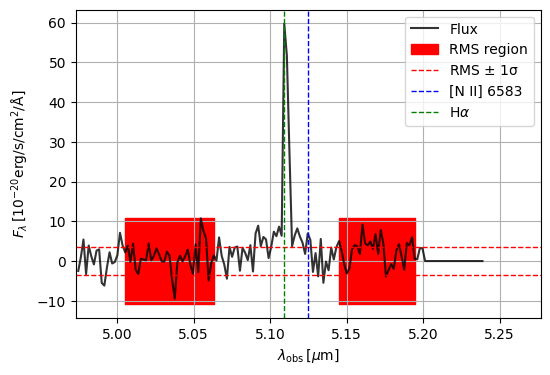

6.6202000000000005
fitting rubies-egs53-v3_g395m-f290lp_4233_53254.spec.fits


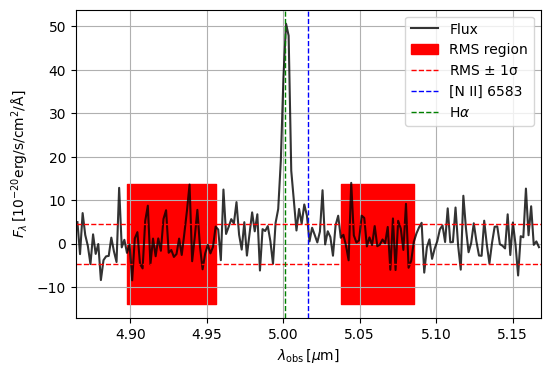

4.9853
fitting rubies-uds43-v3_g395m-f290lp_4233_40800.spec.fits


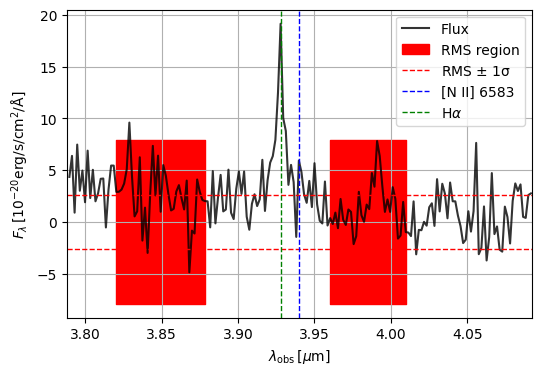

5.27845
fitting rubies-uds33-v3_g395m-f290lp_4233_53692.spec.fits


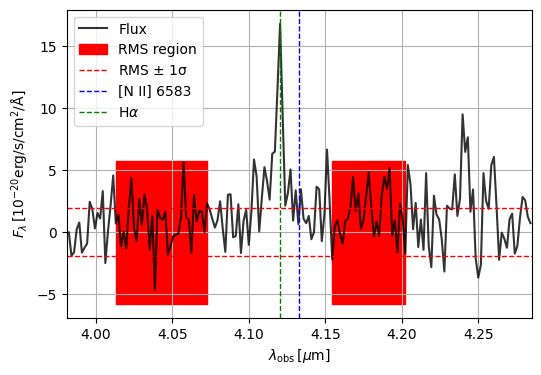

5.127016666666667
fitting rubies-uds41-v3_g395m-f290lp_4233_26611.spec.fits


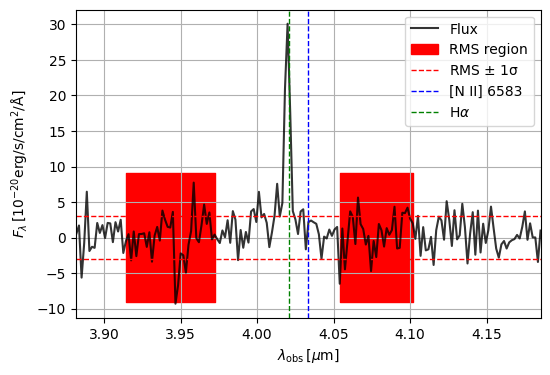

In [ ]:
# line = 'Ha'
# narrowuidlist = [20773, 22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# narrowuidlist = [22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# 计算5个narrow-line LRD 附近的rms，用于对宽线探测的simulation
c = const.c
src_IDs = [8219,12329,16321,20547,22015]  #
plot_margin = 20  # 额外的 Å 范围，确保绘图时有足够的可视区域


rmslist_ = []
zlist = []
for thisuid in src_IDs:
# for thisuid in jade_gal_uid:
    # if thisuid not in narrowuidlist:
    #      continue
    # if thisuid not in [20547]:
    #      continue

    src = uid == thisuid
    # grating = Grating[src][0]
    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        while True:
            try:
                # print(f'Read {url}')
                key = os.path.basename(url)
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                break
            except:
                print('retry')
                continue
        # print(f'Read {url}')
        # key = os.path.basename(url)
        # sobj[key] = msaexp.spectrum.SpectrumSampler(url)

    for j, k in enumerate(sobj):
        if 'g395m' not in k and 'g395h' not in k and 'g235m' not in k:
        # if 'prism' not in k:
            continue
        if(thisuid == 8219 and j == 2):
            continue
        if(thisuid == 22015 and j == 4):
            continue
        print('fitting', k)
        sp = sobj[k]
        grating = k.split('_')[1] + str(j)

        # reference_wavelength = reference_wavelength
        # obs_wavelength = reference_wavelength * (1 + z)
        # fit_line_id = fit_line_id
        gaussians = []
        component_results = {}
        auto_bounds = False
        max_flux = None
        mask = sp.valid > 0
        w_obs = sp.spec_wobs[mask] / (1 + z) * 10000
        flux = sp.spec['flux'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        flux_err = sp.spec['err'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        max_flux = np.max(flux)
        # v_obs = (w_obs - reference_wavelength) / reference_wavelength * c.to('km/s').value


        # 计算 [N II] 6583 和 Hα 6563 的观测波长
        lambda_nii_obs = 6583 * (1 + z) / 10000  # 单位：μm
        lambda_ha_obs = 6563 * (1 + z) / 10000   # 单位：μm

        # 示例：自定义选择范围
        rms_intervals = [(-1200, -600), (200,  700)]  # 单位：Å
        mask_rms = get_rms_mask(sp, lambda_nii_obs, rms_intervals)
        
        # 计算 RMS
        flux_err_rms = sp.spec['flux'][mask_rms] * sp.spec['to_flam'][mask_rms] * (1 + z)
        rms_nii = np.std(flux_err_rms)
        rmslist_.append(rms_nii)
        zlist.append(z)
        # 画图
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # 仅画出感兴趣的区域
        delta_max = 1500
        zoom_range = delta_max + plot_margin  # 总的缩放范围

        zoom_mask = (sp.spec_wobs > (lambda_nii_obs - zoom_range / 10000)) & \
                    (sp.spec_wobs < (lambda_nii_obs + zoom_range / 10000))

        ax.plot(sp.spec_wobs[zoom_mask], sp.spec['flux'][zoom_mask] * sp.spec['to_flam'][zoom_mask] * (1 + z),
                color='black', alpha=0.8, label="Flux")
        
        # 阴影标注选择的RMS计算区域
        ax.fill_between(sp.spec_wobs, -3*rms_nii, 3*rms_nii, where=mask_rms, color='red', alpha=1, label="RMS region")
        
        # 画 RMS 水平线
        ax.axhline(y=rms_nii, color='r', linestyle='--', lw=1, label=r'RMS $\pm$ 1σ')
        ax.axhline(y=-rms_nii, color='r', linestyle='--', lw=1)
        
        # 标注 [N II] 和 Hα 线位置
        ax.axvline(x=lambda_nii_obs, color='b', linestyle='--', lw=1, label=r'[N II] 6583')
        ax.axvline(x=lambda_ha_obs, color='g', linestyle='--', lw=1, label=r'H$\alpha$')
        
        # 轴标签
        ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')
        ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm^2/\AA}]$')
        
        xlim_min = lambda_nii_obs - (delta_max + plot_margin) / 10000
        xlim_max = lambda_nii_obs + (delta_max + plot_margin) / 10000

        ax.set_xlim(xlim_min, xlim_max)
        ax.legend()
        ax.grid()
        
        plt.show()


In [8]:
rmslist_

[3.579498477581536,
 4.608264966243551,
 2.633066260924914,
 1.9275543094251015,
 3.0067429858357437]

4.9853
fitting rubies-uds43-v3_g395m-f290lp_4233_40800.spec.fits


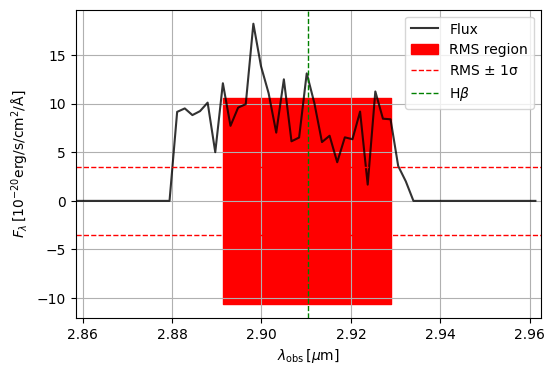

In [ ]:
# line = 'Ha'
# narrowuidlist = [20773, 22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# narrowuidlist = [22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
c = const.c
src_IDs = [16321]  #


rmslist_ = []
zlist = []
for thisuid in src_IDs:
    src = uid == thisuid
    # grating = Grating[src][0]
    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        while True:
            try:
                key = os.path.basename(url)
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                break
            except:
                print('retry')
                continue
    for j, k in enumerate(sobj):
        if 'g395m' not in k and 'g395h' not in k and 'g235m' not in k:
        # if 'prism' not in k:
            continue
        if(thisuid == 8219 and j == 2):
            continue
        if(thisuid == 22015 and j == 4):
            continue
        print('fitting', k)
        sp = sobj[k]
        grating = k.split('_')[1] + str(j)

        gaussians = []
        component_results = {}
        auto_bounds = False
        max_flux = None
        mask = sp.valid > 0
        w_obs = sp.spec_wobs[mask] / (1 + z) * 10000
        flux = sp.spec['flux'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        flux_err = sp.spec['err'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        max_flux = np.max(flux)

        lambda_nii_obs = 6583 * (1 + z) / 10000  # 单位：μm
        lambda_ha_obs = 6563 * (1 + z) / 10000   # 单位：μm
        lambda_hb_obs = 4862.68 * (1 + z) / 10000   # 单位：μm

        # 示例：自定义选择范围
        rms_intervals = [(-200, 200)]  # 单位：Å
        mask_rms = get_rms_mask(sp, lambda_hb_obs, rms_intervals)
        
        # 计算 RMS
        flux_err_rms = sp.spec['flux'][mask_rms] * sp.spec['to_flam'][mask_rms] * (1 + z)
        rms_nii = np.std(flux_err_rms)
        rmslist_.append(rms_nii)
        zlist.append(z)
        # 画图
        fig, ax = plt.subplots(figsize=(6, 4))
        # 仅画出感兴趣的区域
        delta_max = 500
        zoom_range = delta_max + plot_margin  # 总的缩放范围

        zoom_mask = (sp.spec_wobs > (lambda_hb_obs - zoom_range / 10000)) & \
                    (sp.spec_wobs < (lambda_hb_obs + zoom_range / 10000))

        ax.plot(sp.spec_wobs[zoom_mask], sp.spec['flux'][zoom_mask] * sp.spec['to_flam'][zoom_mask] * (1 + z),
                color='black', alpha=0.8, label="Flux")
        
        # 阴影标注选择的RMS计算区域
        ax.fill_between(sp.spec_wobs, -3*rms_nii, 3*rms_nii, where=mask_rms, color='red', alpha=1, label="RMS region")
        
        # 画 RMS 水平线
        ax.axhline(y=rms_nii, color='r', linestyle='--', lw=1, label=r'RMS $\pm$ 1σ')
        ax.axhline(y=-rms_nii, color='r', linestyle='--', lw=1)
        
        # 标注 [N II] 和 Hα 线位置
        # ax.axvline(x=lambda_nii_obs, color='b', linestyle='--', lw=1, label=r'[N II] 6583')
        ax.axvline(x=lambda_hb_obs, color='g', linestyle='--', lw=1, label=r'H$\beta$')
        
        # 轴标签
        ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')
        ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm^2/\AA}]$')
        plot_margin = 20  # 额外的 Å 范围，确保绘图时有足够的可视区域
        xlim_min = lambda_hb_obs - (delta_max + plot_margin) / 10000
        xlim_max = lambda_hb_obs + (delta_max + plot_margin) / 10000

        ax.set_xlim(xlim_min, xlim_max)
        ax.legend()
        ax.grid()
        
        plt.show()


In [73]:
rmslist = np.array([3.2362190428148425])/1e20
z = np.array(zlist)
reference_wavelength = 4862.68*u.AA


width_v = np.array([219.73])

# params[f'{prefix}de_convoved_width'] = de_convoved_width
# params[f'{prefix}de_convoved_width_err'] = de_convoved_width_err
peak = rmslist*5
width_AA = width_v * reference_wavelength / const.c.to('km/s').value
# width_err_AA = width_v_err * reference_wavelength / const.c.to('km/s').value
# Calculate flux and flux error
flux = peak * width_AA * np.sqrt(2 * np.pi)

# calculate luminosity
lumdis = cosmo.luminosity_distance(z)
luminosity = flux * 4 * np.pi * lumdis.to('cm').value ** 2
luminosity.value

array([3.89970037e+41])

In [58]:
rmslist = np.array(rmslist_)/1e20
z = np.array(zlist)
reference_wavelength = 6583*u.AA


width_v = np.array([90.340, 140.386, 219.73, 143.342, 115.870])

# params[f'{prefix}de_convoved_width'] = de_convoved_width
# params[f'{prefix}de_convoved_width_err'] = de_convoved_width_err
peak = rmslist*5
width_AA = width_v * reference_wavelength / const.c.to('km/s').value
# width_err_AA = width_v_err * reference_wavelength / const.c.to('km/s').value
# Calculate flux and flux error
flux = peak * width_AA * np.sqrt(2 * np.pi)

# calculate luminosity
lumdis = cosmo.luminosity_distance(z)
luminosity = flux * 4 * np.pi * lumdis.to('cm').value ** 2


7301
5.93678
fitting gds-deep-v3_g235m-f170lp_1210_13176.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13176.spec.fits


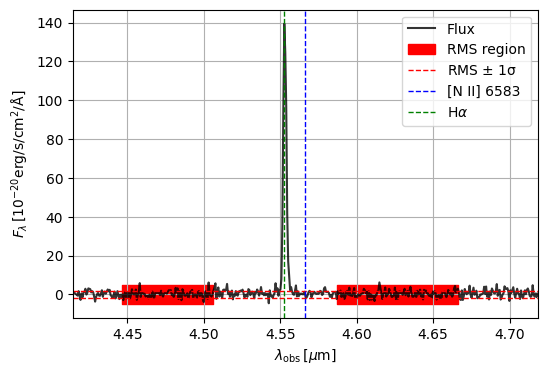

fitting gds-deep-v3_g395m-f290lp_1210_13176.spec.fits


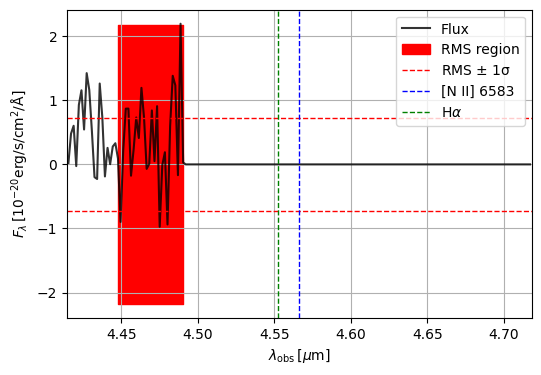

7302
6.3370999999999995
fitting gds-deep-v3_g235m-f170lp_1210_13197.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13197.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_13197.spec.fits


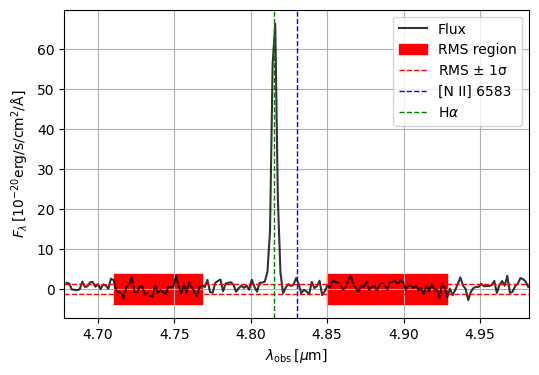

7304
3.7303666666666664
fitting gds-deep-v3_g235m-f170lp_1210_13352.spec.fits


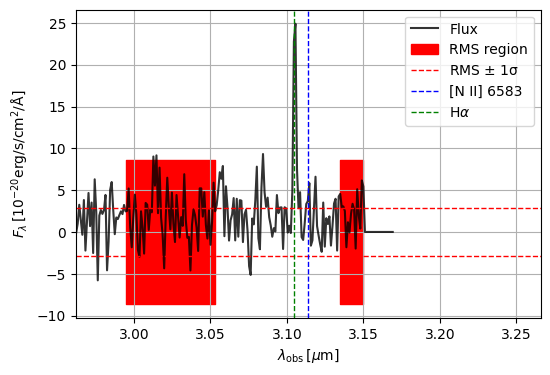

fitting gds-deep-v3_g395h-f290lp_1210_13352.spec.fits


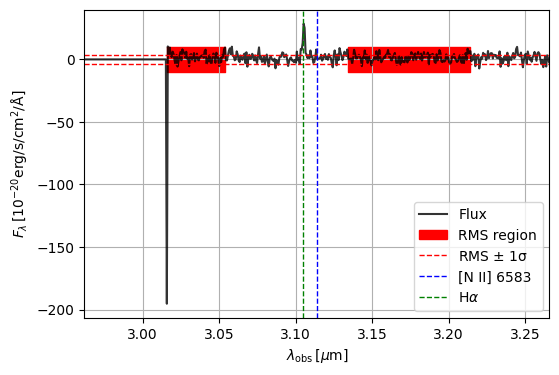

7308
3.4685499999999996
fitting gds-deep-v3_g235m-f170lp_1210_13491.spec.fits


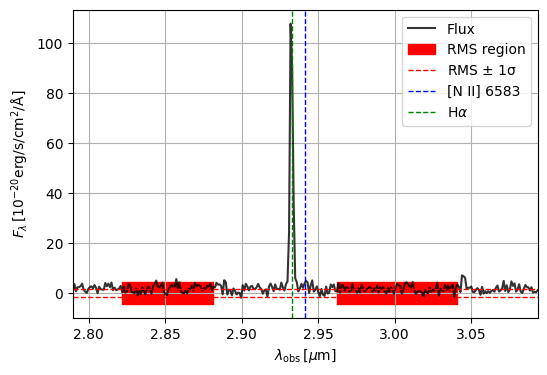

fitting gds-deep-v3_g395h-f290lp_1210_13491.spec.fits


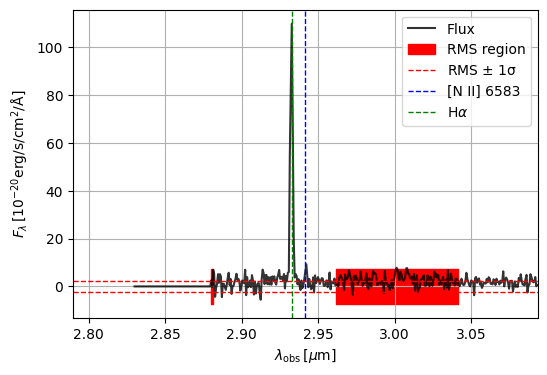

fitting gds-deep-v3_g395m-f290lp_1210_13491.spec.fits


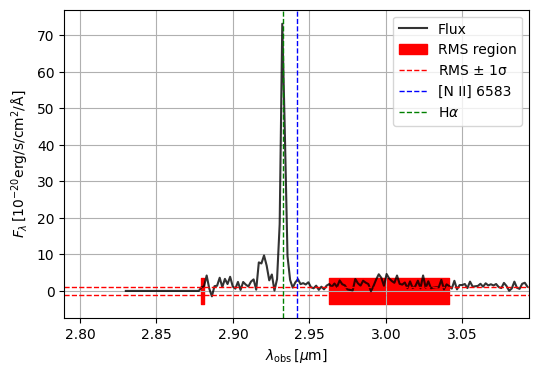

7309
4.037675
fitting gds-deep-v3_g235m-f170lp_1210_13545.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13545.spec.fits


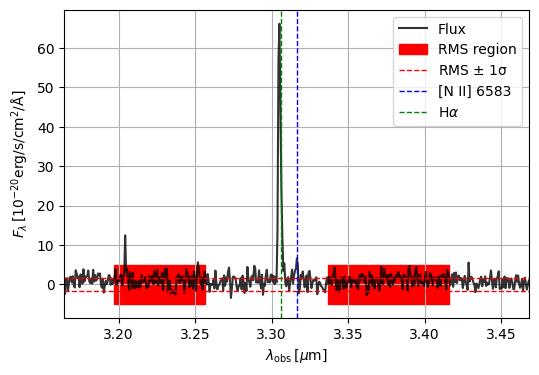

7310
5.56835
fitting gds-deep-v3_g235m-f170lp_1210_13577.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13577.spec.fits


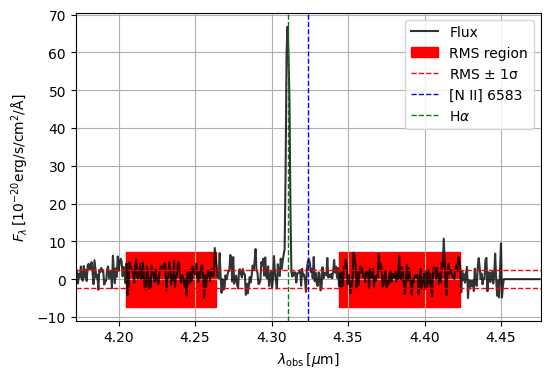

fitting gds-deep-v3_g395m-f290lp_1210_13577.spec.fits


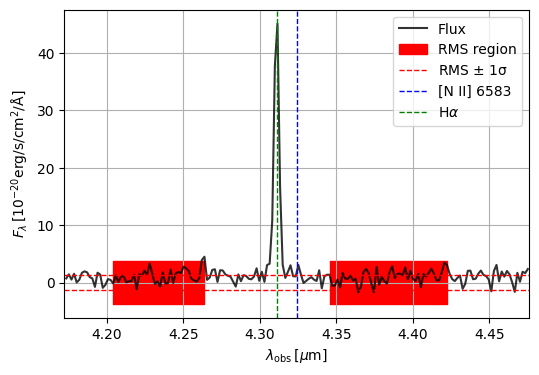

7311
3.3268999999999997
fitting gds-deep-v3_g235m-f170lp_1210_13597.spec.fits


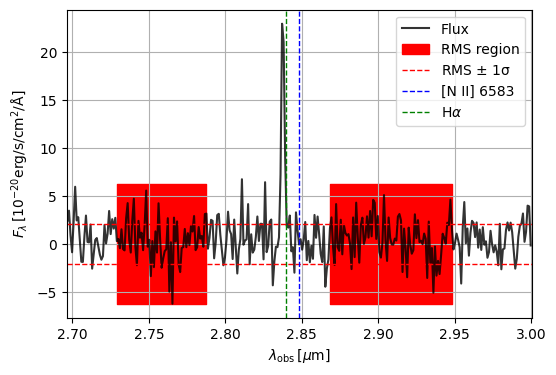

fitting gds-deep-v3_g395h-f290lp_1210_13597.spec.fits


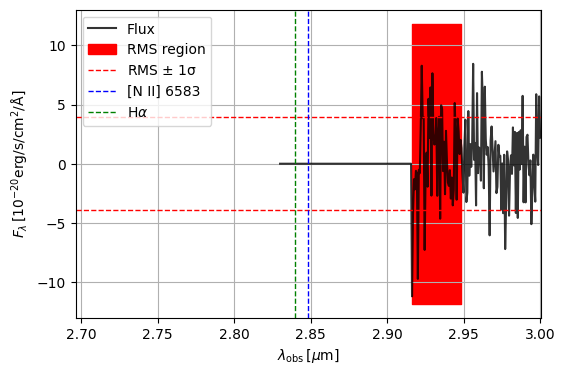

7312
6.929875
fitting gds-deep-v3_g235m-f170lp_1210_13609.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13609.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_13609.spec.fits


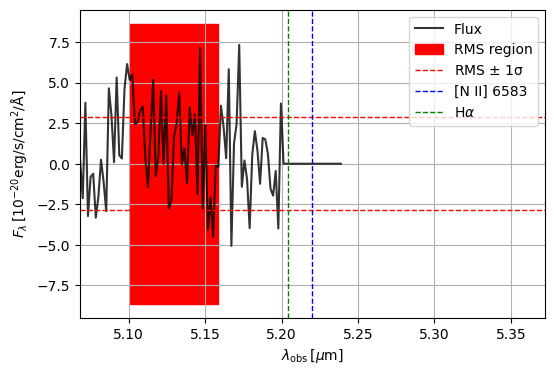

7313
5.946783333333333
fitting gds-deep-v3_g235m-f170lp_1210_13618.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13618.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_13618.spec.fits


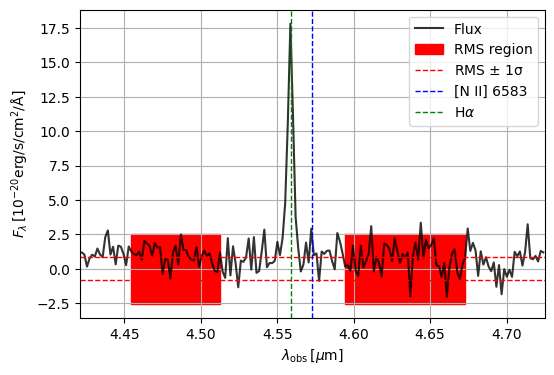

fitting jades-gds-wide-v3_g395m-f290lp_1180_13618.spec.fits


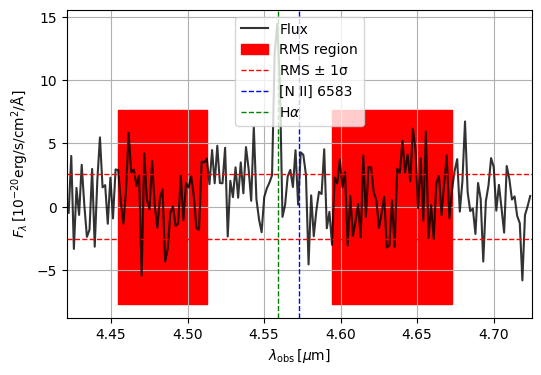

7314
5.918683333333334
fitting gds-deep-v3_g395h-f290lp_1210_13620.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_13620.spec.fits


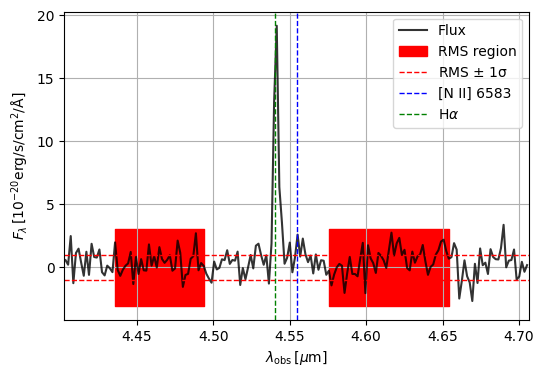

fitting jades-gds-wide-v3_g235m-f170lp_1180_13620.spec.fits
fitting jades-gds-wide-v3_g395m-f290lp_1180_13620.spec.fits


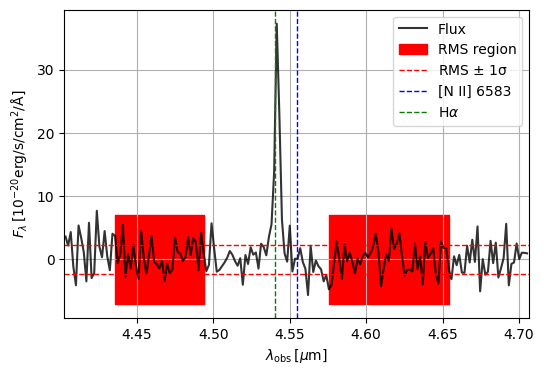

7315
7.2772
fitting gds-deep-v3_g395m-f290lp_1210_13682.spec.fits
7318
4.903200000000001
fitting gds-deep-v3_g235m-f170lp_1210_13846.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_13846.spec.fits


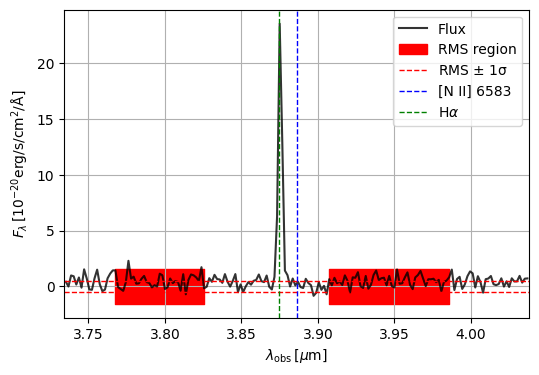

7319
4.883933333333334
fitting gds-deep-v3_g235m-f170lp_1210_13854.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13854.spec.fits


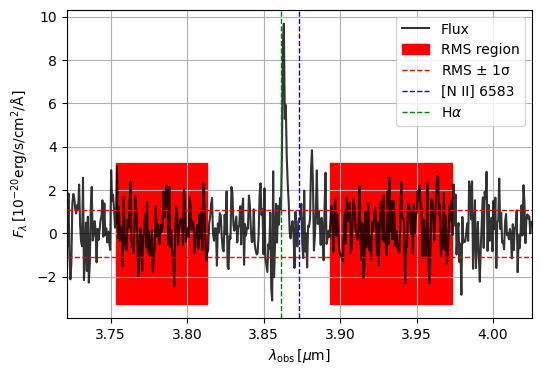

fitting gds-deep-v3_g395m-f290lp_1210_13854.spec.fits


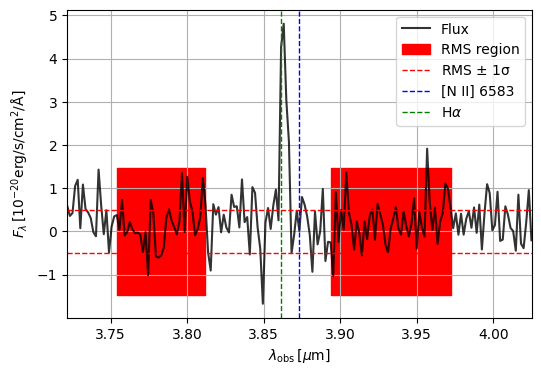

fitting jades-gds-wide-v3_g395m-f290lp_1180_13854.spec.fits


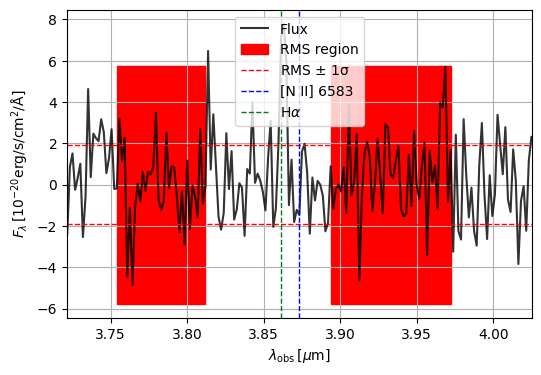

7320
5.6145499999999995
fitting gds-deep-v3_g395m-f290lp_1210_13877.spec.fits


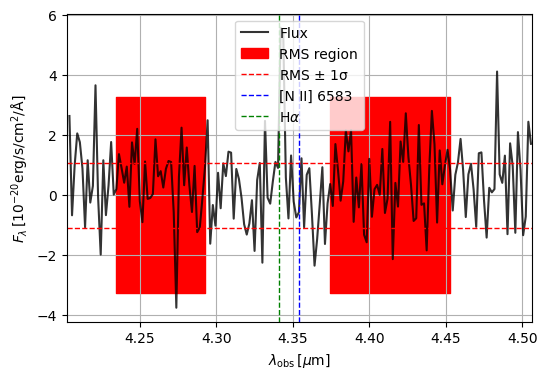

7322
7.199199999999999
fitting gds-deep-v3_g395h-f290lp_1210_13905.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_13905.spec.fits
fitting jades-gds-wide-v3_g395m-f290lp_1180_13905.spec.fits
7323
3.1536666666666666
fitting gds-deep-v3_g235m-f170lp_1210_13980.spec.fits


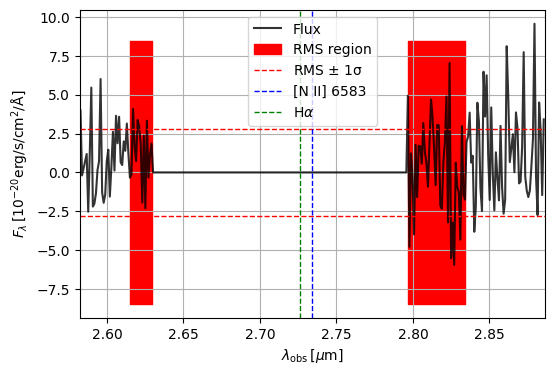

fitting gds-deep-v3_g395h-f290lp_1210_13980.spec.fits
7327
5.765725
fitting gds-deep-v3_g235m-f170lp_1210_15099.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_15099.spec.fits


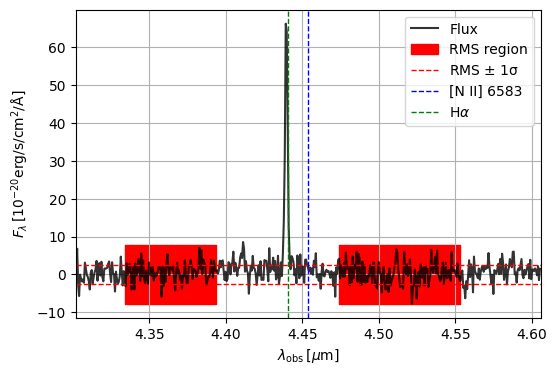

fitting gds-deep-v3_g395m-f290lp_1210_15099.spec.fits


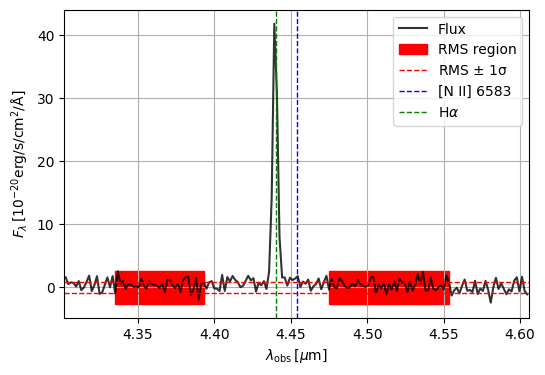

7328
5.937525
fitting gds-deep-v3_g395h-f290lp_1210_15125.spec.fits


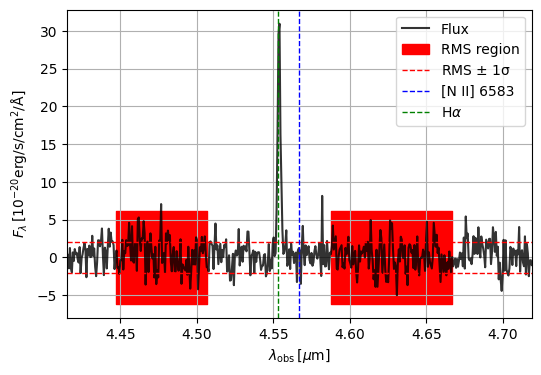

fitting gds-deep-v3_g395m-f290lp_1210_15125.spec.fits


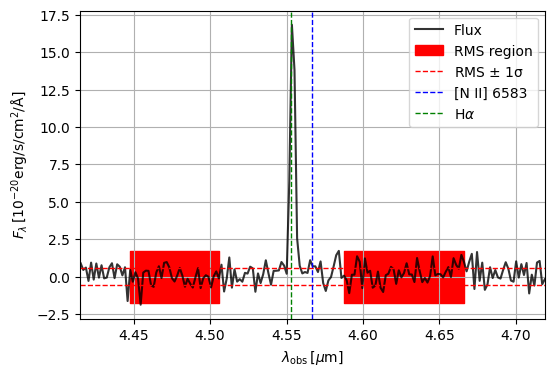

7329
4.14895
fitting gds-deep-v3_g235m-f170lp_1210_15157.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_15157.spec.fits


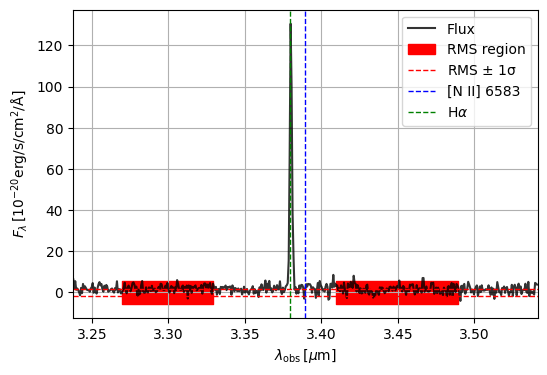

fitting gds-deep-v3_g395m-f290lp_1210_15157.spec.fits


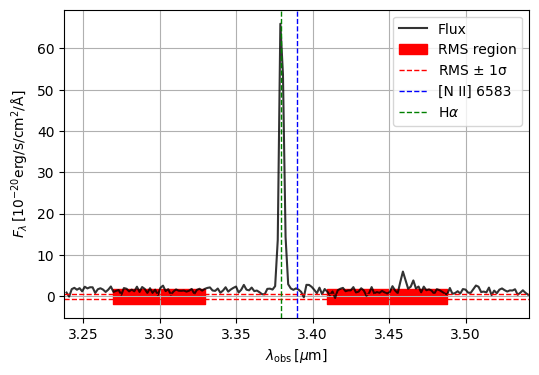

7330
5.0760250000000005
fitting gds-deep-v3_g235m-f170lp_1210_15338.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_15338.spec.fits


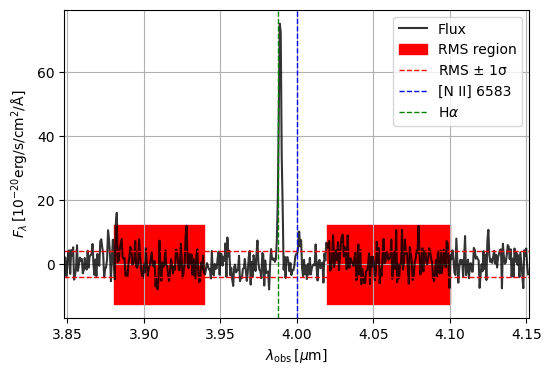

fitting gds-deep-v3_g395m-f290lp_1210_15338.spec.fits


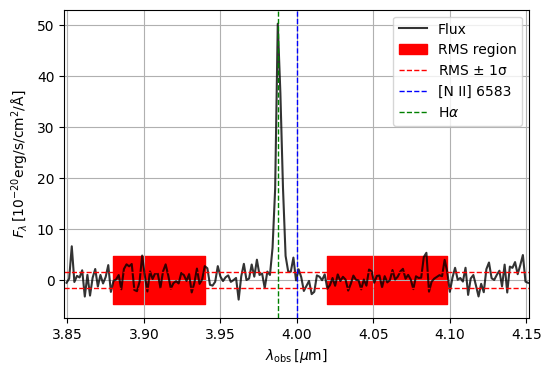

7334
3.929825
fitting gds-deep-v3_g235m-f170lp_1210_16186.spec.fits


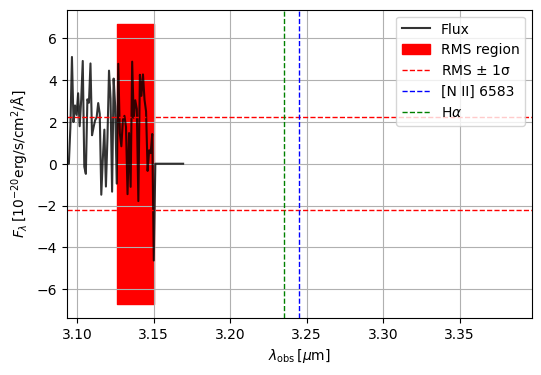

fitting gds-deep-v3_g395h-f290lp_1210_16186.spec.fits


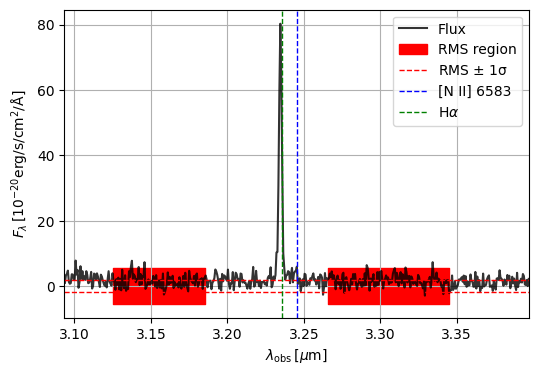

fitting gds-deep-v3_g395m-f290lp_1210_16186.spec.fits


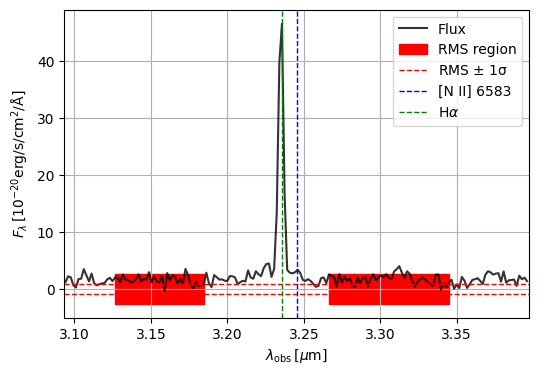

7335
5.504575000000001
fitting gds-deep-v3_g235m-f170lp_1210_16374.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_16374.spec.fits


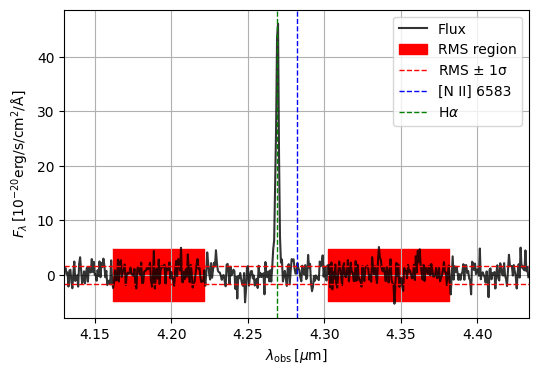

fitting gds-deep-v3_g395m-f290lp_1210_16374.spec.fits


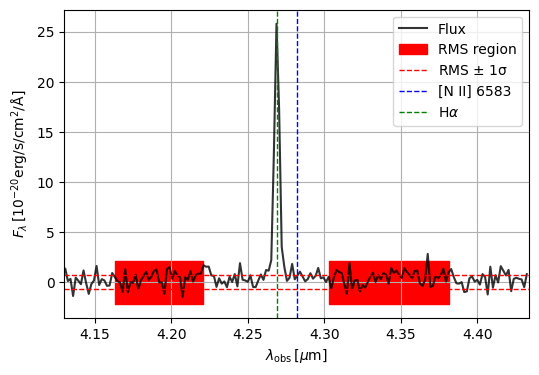

7338
4.283799999999999
fitting gds-deep-v3_g235m-f170lp_1210_1916.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_1916.spec.fits


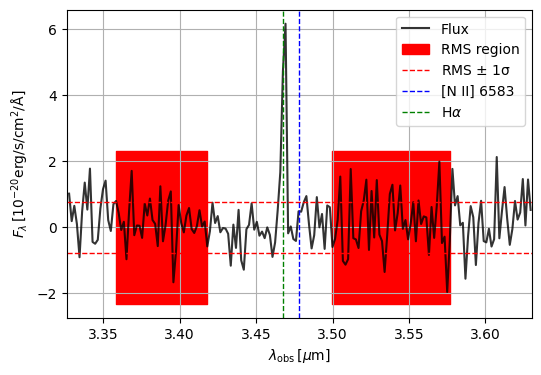

7339
5.44355
fitting gds-deep-v3_g395h-f290lp_1210_1939.spec.fits


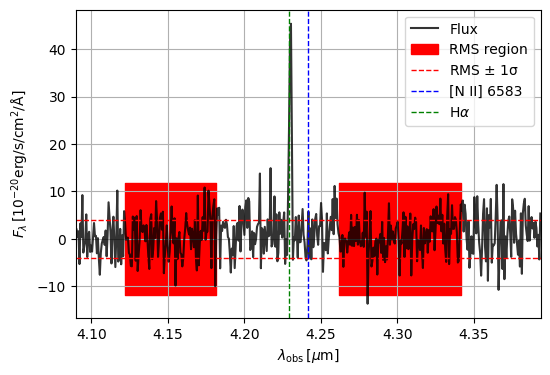

fitting gds-deep-v3_g395m-f290lp_1210_1939.spec.fits
7341
5.43845
fitting gds-deep-v3_g395h-f290lp_1210_2075.spec.fits


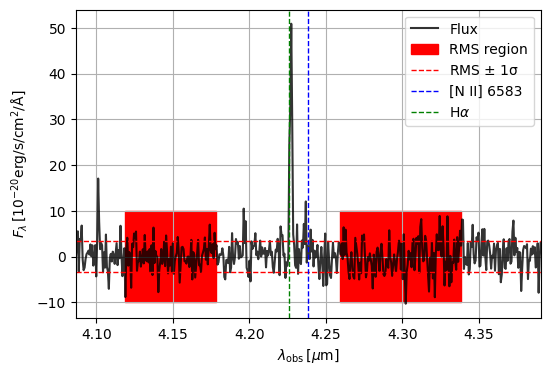

fitting gds-deep-v3_g395m-f290lp_1210_2075.spec.fits


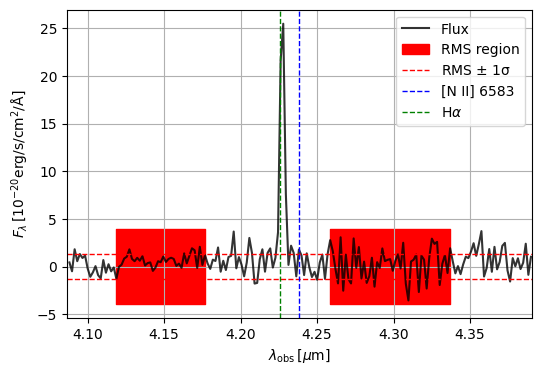

7342
3.0147500000000003
fitting gds-deep-v3_g235m-f170lp_1210_214.spec.fits


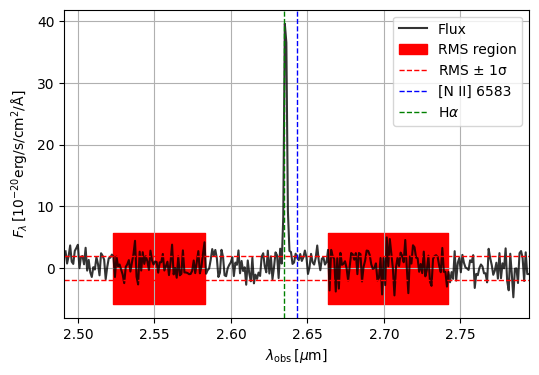

7345
3.588675
fitting gds-deep-v3_g235m-f170lp_1210_35295.spec.fits


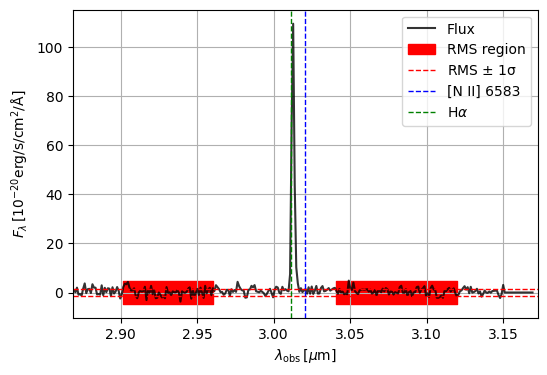

fitting gds-deep-v3_g395h-f290lp_1210_35295.spec.fits


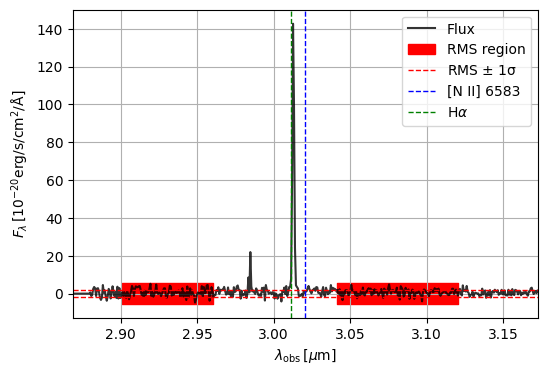

fitting gds-deep-v3_g395m-f290lp_1210_35295.spec.fits


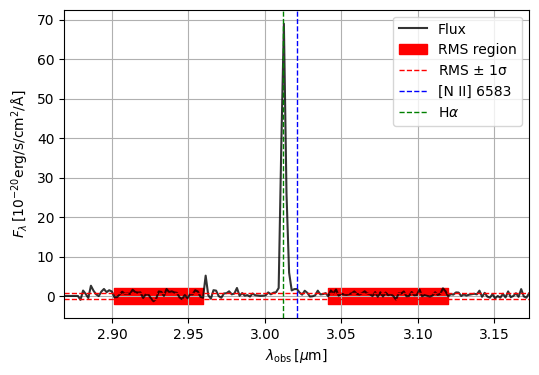

7362
5.821375000000001
fitting gds-deep-v3_g235m-f170lp_1210_5113.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_5113.spec.fits


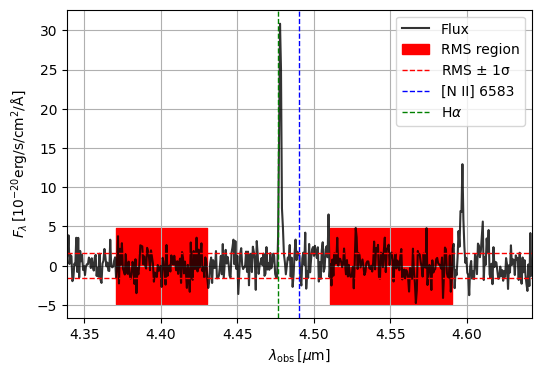

fitting gds-deep-v3_g395m-f290lp_1210_5113.spec.fits


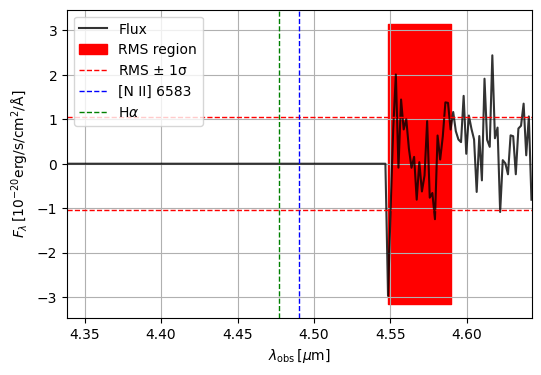

7364
7.98215
fitting gds-deep-v3_g395h-f290lp_1210_5173.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_5173.spec.fits
fitting jades-gds-wide-v3_g395m-f290lp_1180_5173.spec.fits
7367
6.616175
fitting gds-deep-v3_g395h-f290lp_1210_5447.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_5447.spec.fits


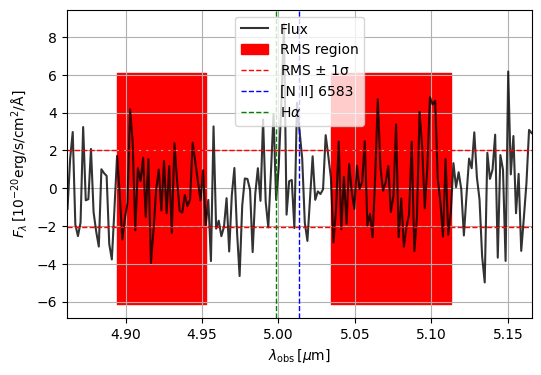

7371
5.816725
fitting gds-deep-v3_g395h-f290lp_1210_56849.spec.fits


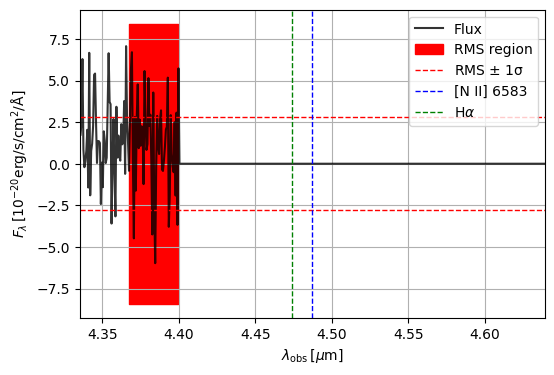

fitting gds-deep-v3_g395m-f290lp_1210_56849.spec.fits


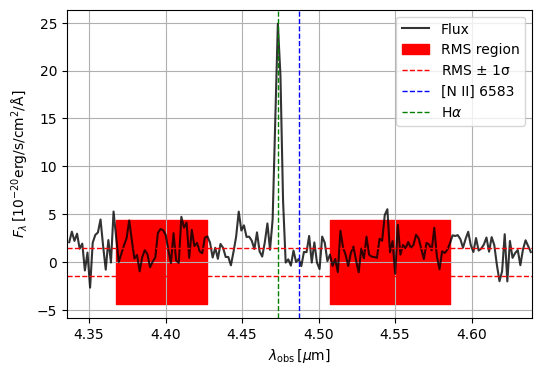

7566
8.4725
fitting gds-deep-v3_g395m-f290lp_1210_6139.spec.fits
fitting jades-gds-wide-v3_g235m-f170lp_1180_6139.spec.fits
fitting jades-gds-wide-v3_g395m-f290lp_1180_6139.spec.fits
7591
4.465625
fitting gds-deep-v3_g235m-f170lp_1210_626.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_626.spec.fits


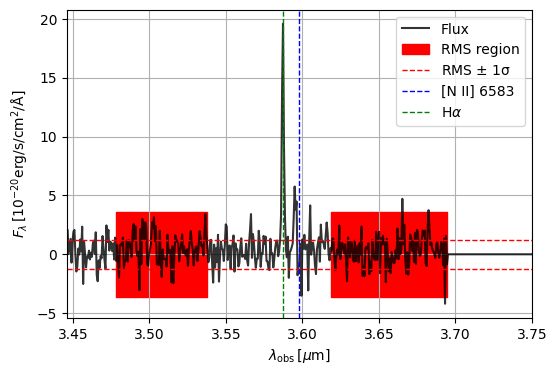

fitting gds-deep-v3_g395m-f290lp_1210_626.spec.fits


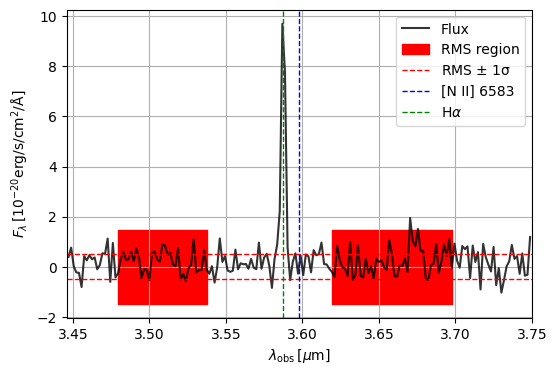

7600
3.08938
fitting gds-deep-v3_g235m-f170lp_1210_7948.spec.fits


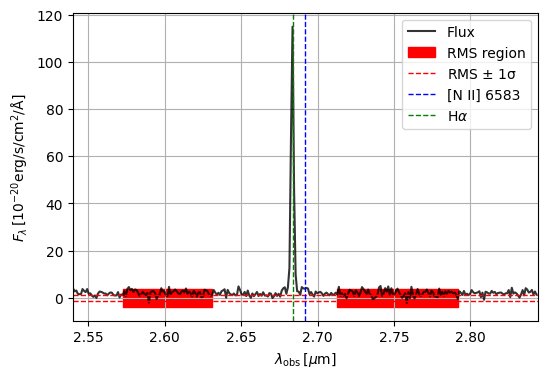

fitting gds-deep-v3_g395h-f290lp_1210_7948.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_7948.spec.fits
7605
3.3205999999999998
fitting gds-deep-v3_g235m-f170lp_1210_8105.spec.fits


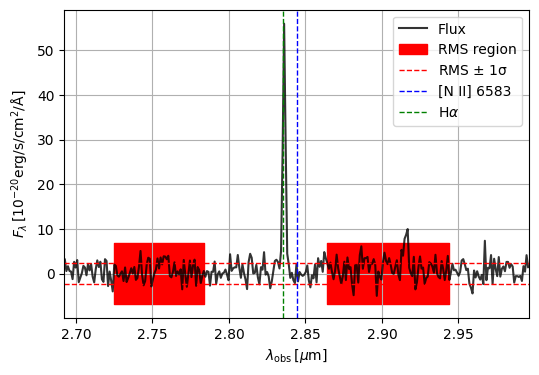

7607
6.328033333333334
fitting gds-deep-v3_g395h-f290lp_1210_8253.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_8253.spec.fits


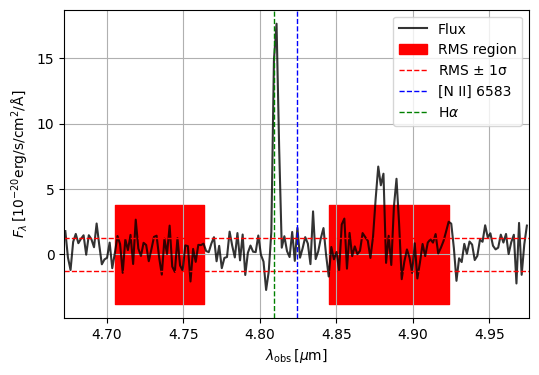

7613
4.04305
fitting gds-deep-v3_g235m-f170lp_1210_9306.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9306.spec.fits


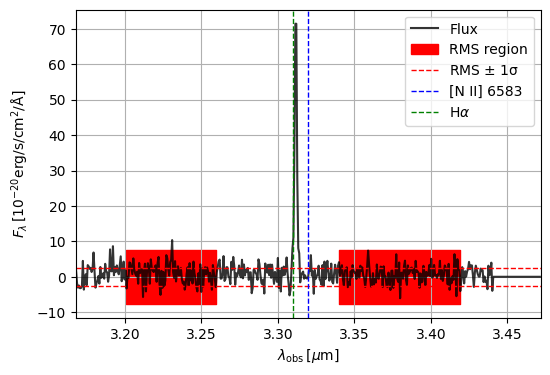

fitting gds-deep-v3_g395m-f290lp_1210_9306.spec.fits


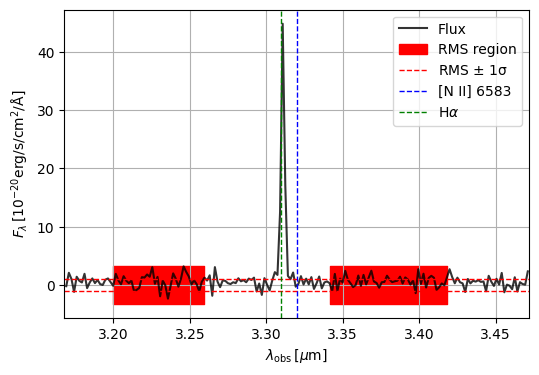

7617
5.8873500000000005
fitting gds-deep-v3_g235m-f170lp_1210_9414.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9414.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_9414.spec.fits


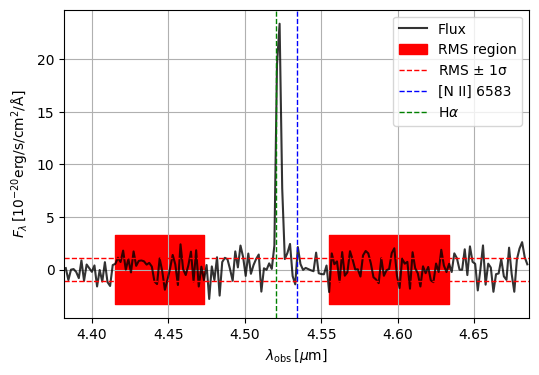

7618
4.231400000000001
fitting gds-deep-v3_g235m-f170lp_1210_9451.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9451.spec.fits


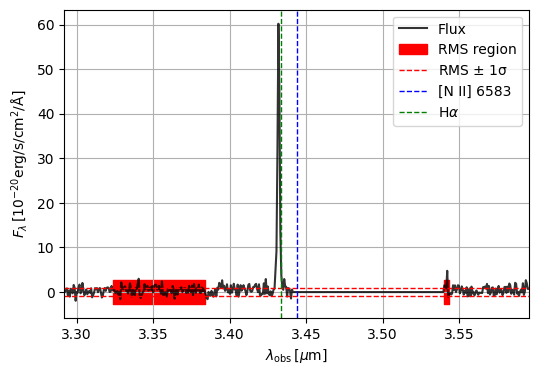

fitting gds-deep-v3_g395m-f290lp_1210_9451.spec.fits


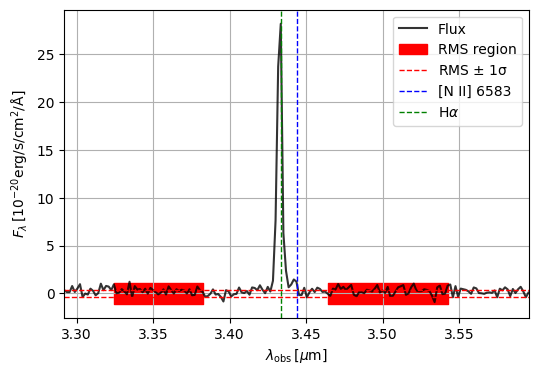

7619
4.0237
fitting gds-deep-v3_g235m-f170lp_1210_9489.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9489.spec.fits


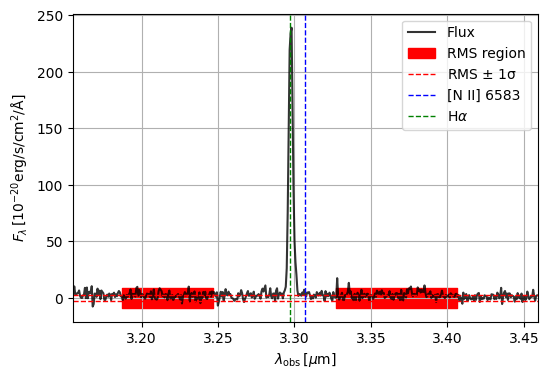

fitting gds-deep-v3_g395m-f290lp_1210_9489.spec.fits


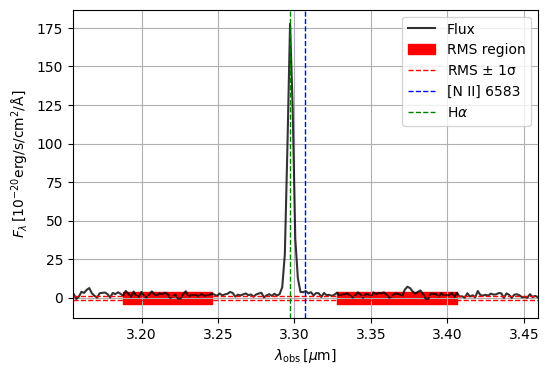

7621
3.599425
fitting gds-deep-v3_g235m-f170lp_1210_9506.spec.fits


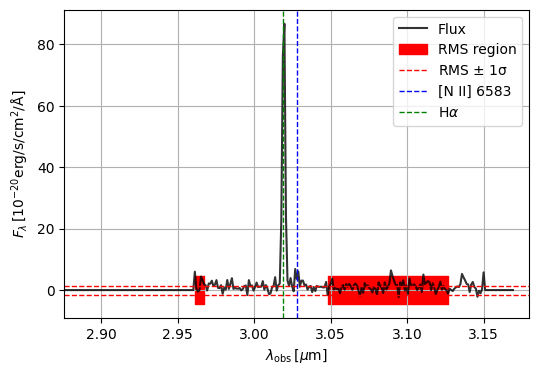

fitting gds-deep-v3_g395h-f290lp_1210_9506.spec.fits


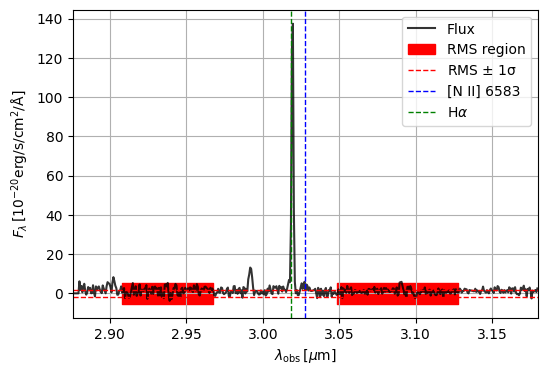

fitting gds-deep-v3_g395m-f290lp_1210_9506.spec.fits


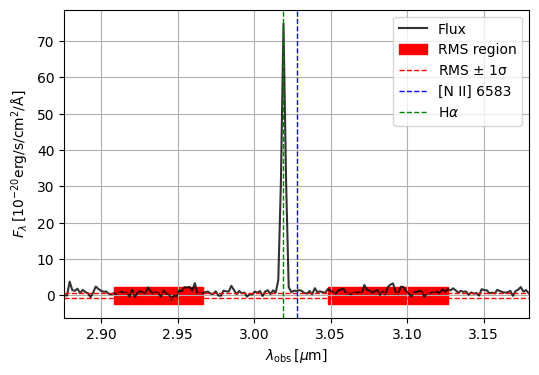

7627
3.5786000000000002
fitting gds-deep-v3_g235m-f170lp_1210_9694.spec.fits


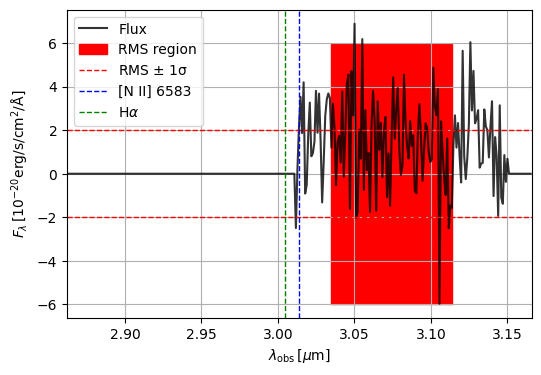

fitting gds-deep-v3_g395h-f290lp_1210_9694.spec.fits


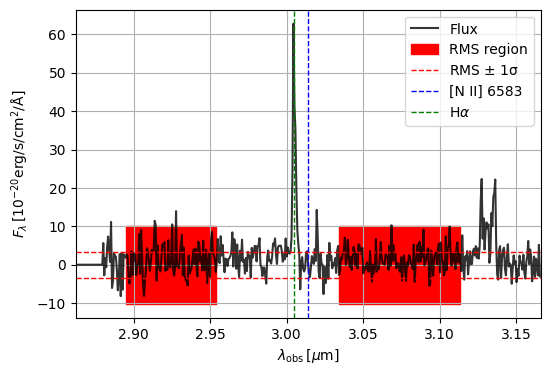

fitting gds-deep-v3_g395m-f290lp_1210_9694.spec.fits


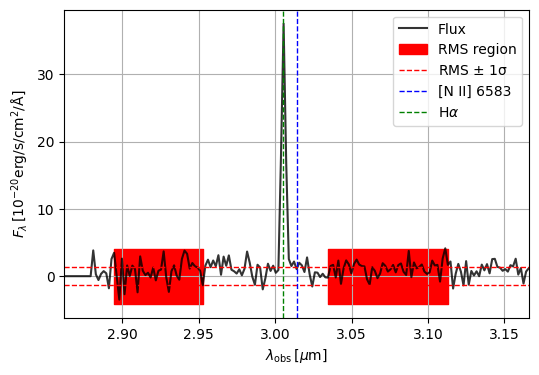

7628
4.80706
fitting gds-deep-v3_g235m-f170lp_1210_9695.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9695.spec.fits


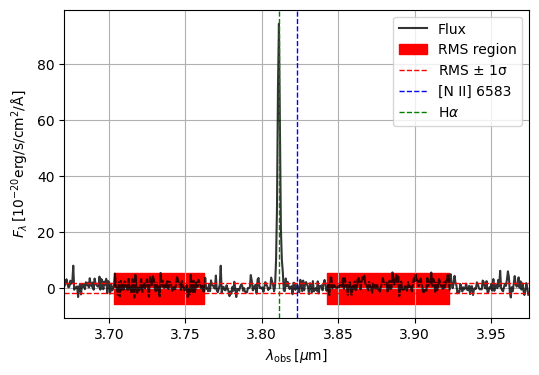

fitting gds-deep-v3_g395m-f290lp_1210_9695.spec.fits


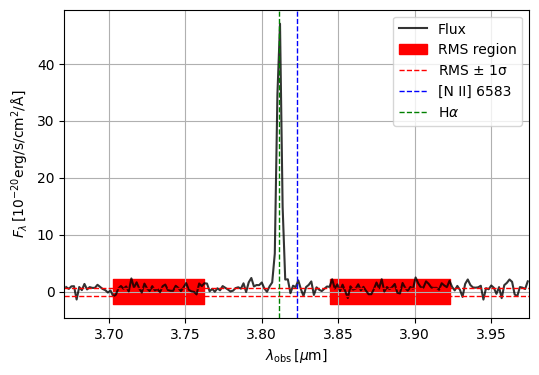

7629
5.799400000000001
fitting gds-deep-v3_g235m-f170lp_1210_9842.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9842.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_9842.spec.fits


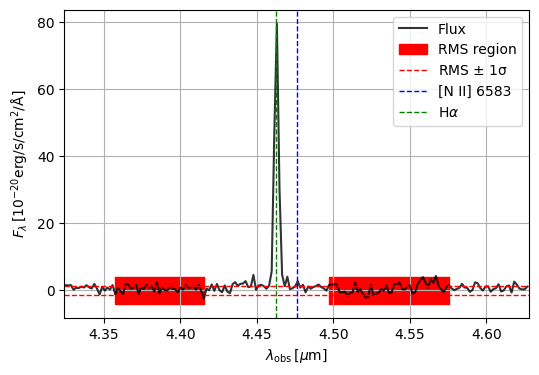

fitting jades-gds-wide-v3_g395m-f290lp_1180_9842.spec.fits


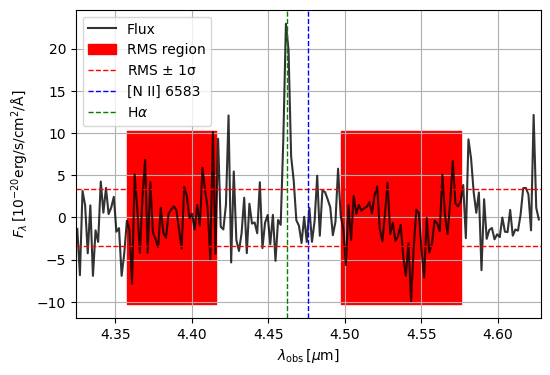

7631
4.135633333333334
fitting gds-deep-v3_g235m-f170lp_1210_9858.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_9858.spec.fits


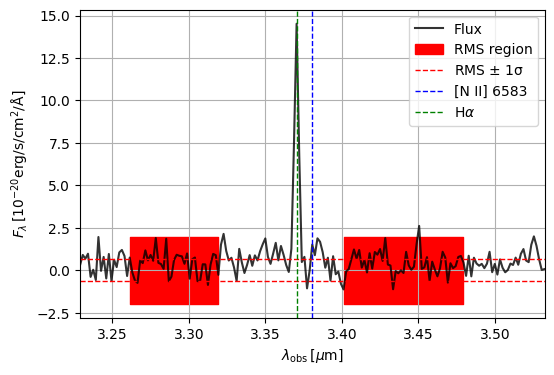

7632
6.1033857142857135
fitting gds-deep-v3_g235m-f170lp_1210_9867.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9867.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_9867.spec.fits


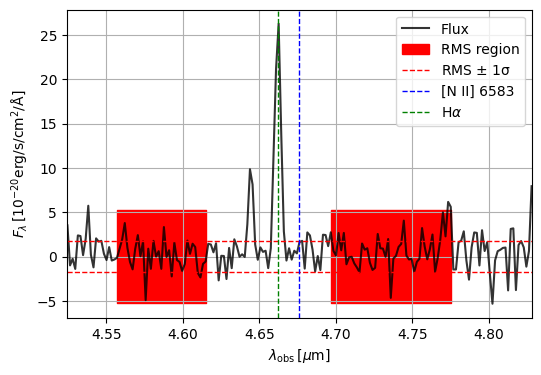

fitting jades-gds-wide-v3_g235m-f170lp_1180_9867.spec.fits
fitting jades-gds-wide-v3_g395m-f290lp_1180_9867.spec.fits


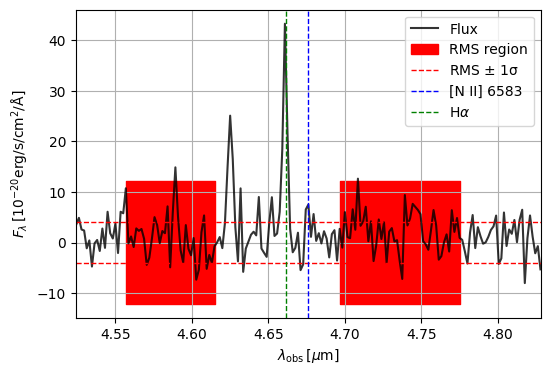

7633
3.605833333333333
fitting gds-deep-v3_g235m-f170lp_1210_9873.spec.fits


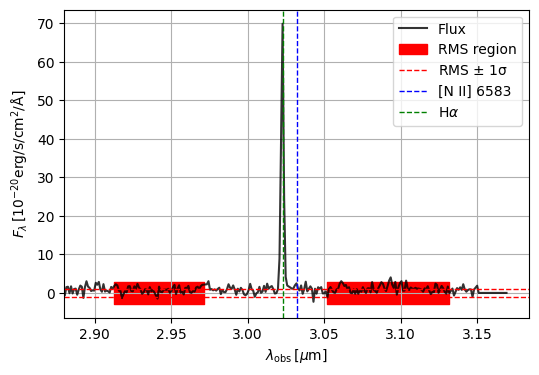

fitting gds-deep-v3_g395m-f290lp_1210_9873.spec.fits


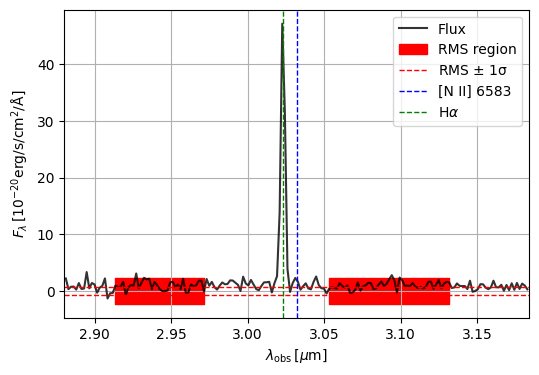

7634
5.976375
fitting gds-deep-v3_g395h-f290lp_1210_9880.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_9880.spec.fits


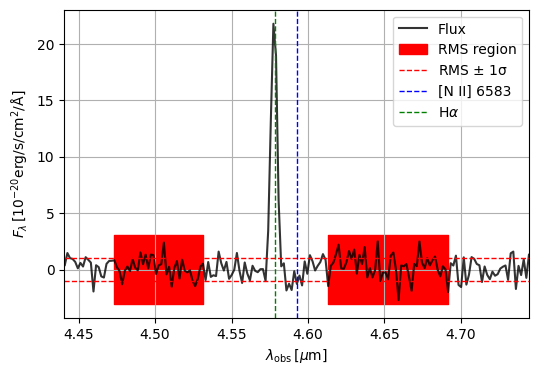

7635
4.774875
fitting gds-deep-v3_g235m-f170lp_1210_9891.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9891.spec.fits


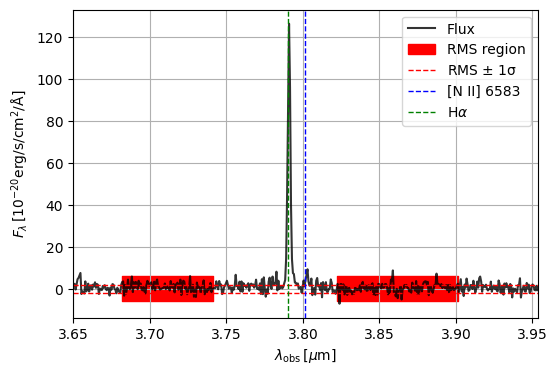

fitting gds-deep-v3_g395m-f290lp_1210_9891.spec.fits


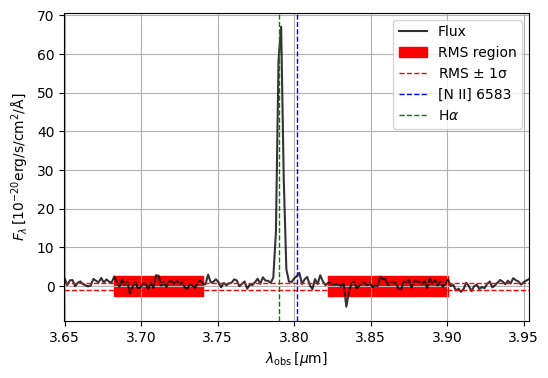

fitting jades-gds-wide-v3_g235m-f170lp_1180_9891.spec.fits
fitting jades-gds-wide-v3_g395m-f290lp_1180_9891.spec.fits


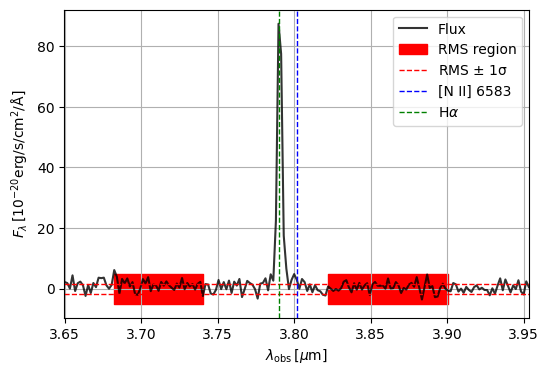

7636
6.632524999999999
fitting gds-deep-v3_g395h-f290lp_1210_9903.spec.fits
fitting gds-deep-v3_g395m-f290lp_1210_9903.spec.fits


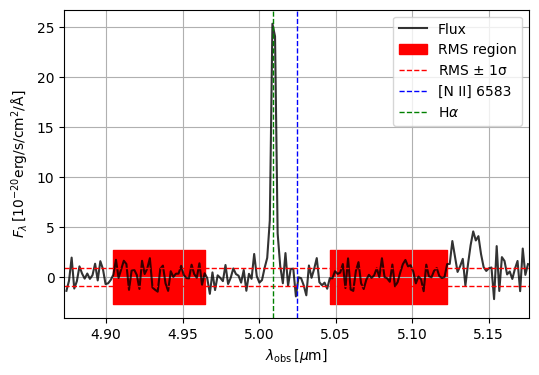

7902
5.1233
7903
3.5832
7904
4.0219
7905
3.4044
7907
3.4473
7908
3.955
7909
4.0264
7922
4.3919
7924
4.8627
7938
4.2331
7939
6.3346
21763
5.05195
fitting gds-deep-v3_g395h-f290lp_1210_5233.spec.fits


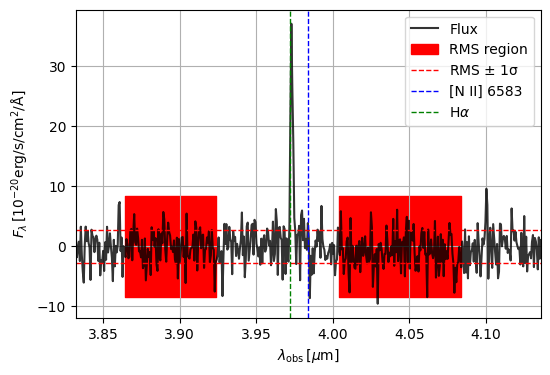

fitting gds-deep-v3_g395m-f290lp_1210_5233.spec.fits


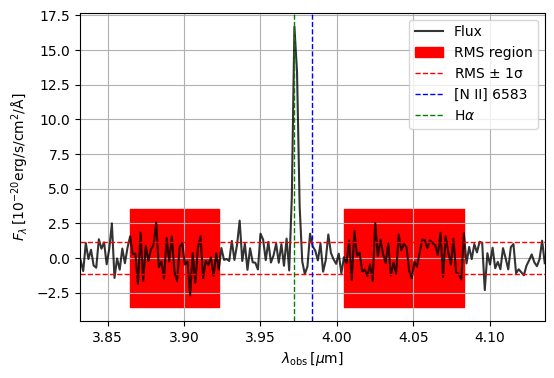

fitting gds-rieke-v3_g235m-f170lp_1207_105635.spec.fits
21773
5.121957142857143
fitting gds-deep-v3_g235m-f170lp_1210_36976.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_36976.spec.fits


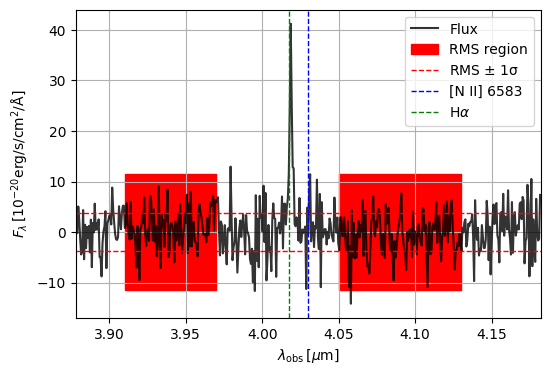

fitting gds-deep-v3_g395m-f290lp_1210_36976.spec.fits


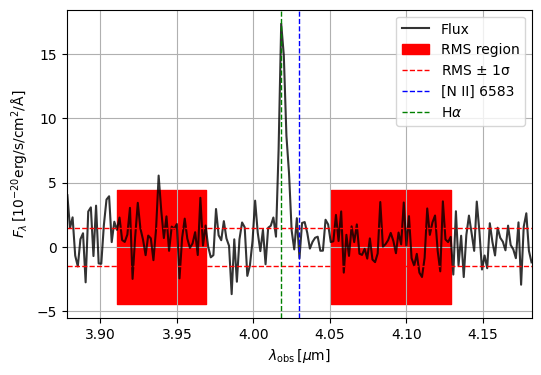

fitting gds-rieke-v3_g235m-f170lp_1207_203112.spec.fits
21812
9.435224999999999
fitting gds-deep-v3_g395m-f290lp_1210_58975.spec.fits
fitting gds-udeep-v3_g395m-f290lp_3215_265801.spec.fits
21837
4.70468
fitting gds-deep-v3_g235m-f170lp_1210_9849.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_9849.spec.fits


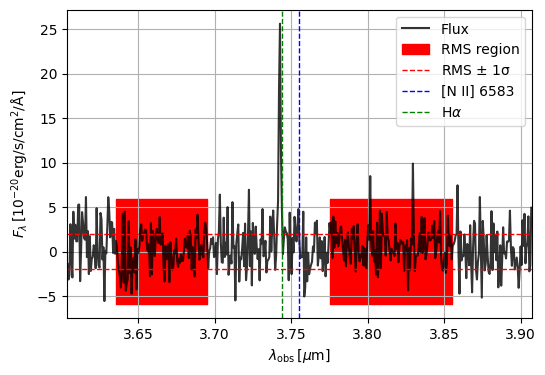

fitting gds-deep-v3_g395m-f290lp_1210_9849.spec.fits


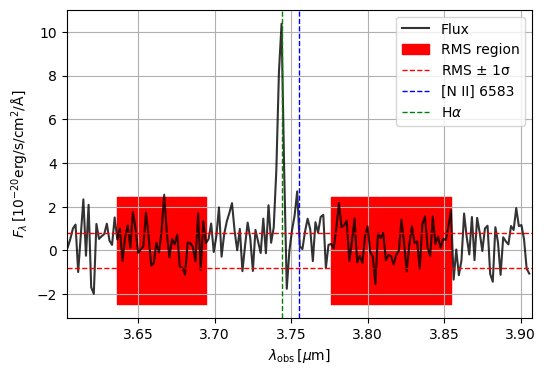

22476
nan
fitting gds-rieke-v3_g235m-f170lp_1207_106885.spec.fits


In [88]:
# jades gal NII_upplimt
from astropy.stats import sigma_clip


# line = 'Ha'
# narrowuidlist = [20773, 22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# narrowuidlist = [22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
c = const.c

uidlist = []
rmslist_ = []
zlist = []
# for thisuid in jade_gal['uid']:
for thisuid in jade_gal_uid:
    # if thisuid not in narrowuidlist:
    #      continue
    # if thisuid not in [20547]:
    #      continue

    src = uid == thisuid
    print(thisuid)
    # grating = Grating[src][0]
    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        while True:
            try:
                # print(f'Read {url}')
                key = os.path.basename(url)
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                break
            except:
                print('retry')
                continue
        # print(f'Read {url}')
        # key = os.path.basename(url)
        # sobj[key] = msaexp.spectrum.SpectrumSampler(url)

    for j, k in enumerate(sobj):
        if 'g395m' not in k and 'g395h' not in k and 'g235m' not in k:
        # if 'prism' not in k:
            continue
        if(thisuid == 8219 and j == 2):
            continue
        if(thisuid == 22015 and j == 4):
            continue
        print('fitting', k)
        sp = sobj[k]
        grating = k.split('_')[1] + str(j)

        # reference_wavelength = reference_wavelength
        # obs_wavelength = reference_wavelength * (1 + z)
        # fit_line_id = fit_line_id
        gaussians = []
        component_results = {}
        auto_bounds = False
        max_flux = None
        mask = sp.valid > 0
        w_obs = sp.spec_wobs[mask] / (1 + z) * 10000
        flux = sp.spec['flux'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        flux_err = sp.spec['err'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        max_flux = np.max(flux)
        # v_obs = (w_obs - reference_wavelength) / reference_wavelength * c.to('km/s').value


        # 计算 [N II] 6583 和 Hα 6563 的观测波长
        lambda_nii_obs = 6583 * (1 + z) / 10000  # 单位：μm
        lambda_ha_obs = 6563 * (1 + z) / 10000   # 单位：μm

        # 示例：自定义选择范围
        rms_intervals = [(-1200, -600), (200,  1000)]  # 单位：Å
        mask_rms = get_rms_mask(sp, lambda_nii_obs, rms_intervals)*mask
        
        # 计算 RMS
        flux_err_rms = sp.spec['flux'][mask_rms] * sp.spec['to_flam'][mask_rms] * (1 + z)
        # rms_nii = np.std(flux_err_rms)
        #sigma clipped rms
        rms_nii = sigma_clip(flux_err_rms, sigma=3, maxiters=3).std()
        if(rms_nii > 0):
            rmslist_.append(rms_nii)
            zlist.append(z)
            uidlist.append(thisuid)
        else:
            rmslist_.append(np.nan)
            zlist.append(z)
            uidlist.append(thisuid)
            continue
        
        # 画图
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # 仅画出感兴趣的区域
        delta_max = 1500
        zoom_range = delta_max + plot_margin  # 总的缩放范围

        zoom_mask = (sp.spec_wobs > (lambda_nii_obs - zoom_range / 10000)) & \
                    (sp.spec_wobs < (lambda_nii_obs + zoom_range / 10000))

        ax.plot(sp.spec_wobs[zoom_mask], sp.spec['flux'][zoom_mask] * sp.spec['to_flam'][zoom_mask] * (1 + z),
                color='black', alpha=0.8, label="Flux")
        
        # 阴影标注选择的RMS计算区域
        ax.fill_between(sp.spec_wobs, -3*rms_nii, 3*rms_nii, where=mask_rms, color='red', alpha=1, label="RMS region")
        
        # 画 RMS 水平线
        ax.axhline(y=rms_nii, color='r', linestyle='--', lw=1, label=r'RMS $\pm$ 1σ')
        ax.axhline(y=-rms_nii, color='r', linestyle='--', lw=1)
        
        # 标注 [N II] 和 Hα 线位置
        ax.axvline(x=lambda_nii_obs, color='b', linestyle='--', lw=1, label=r'[N II] 6583')
        ax.axvline(x=lambda_ha_obs, color='g', linestyle='--', lw=1, label=r'H$\alpha$')
        
        # 轴标签
        ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')
        ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm^2/\AA}]$')
        plot_margin = 20  # 额外的 Å 范围，确保绘图时有足够的可视区域
        xlim_min = lambda_nii_obs - (delta_max + plot_margin) / 10000
        xlim_max = lambda_nii_obs + (delta_max + plot_margin) / 10000

        ax.set_xlim(xlim_min, xlim_max)
        ax.legend()
        ax.grid()
        
        plt.show()


In [103]:
unique_uidlist = np.unique(uidlist)
unique_rms_list = []
unique_z_list = []
for uid in unique_uidlist:
    mask = uidlist == uid
    avaival_rms = np.array(rmslist_)[mask]
    avaival_z = np.array(zlist)[mask]
    if(np.isnan(avaival_rms).all()):
        unique_rms_list.append(np.nan)
        unique_z_list.append(np.nan)
        continue
    else:
        unique_rms_list.append(np.nanmin(avaival_rms))
        unique_z_list.append(np.nanmean(avaival_z))

unique_uidlist = np.array(unique_uidlist)

rmslist = np.array(unique_rms_list)/1e20
z = np.array(unique_z_list)
reference_wavelength = 6583*u.AA


In [101]:
catalog_jadesgal = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/LRD_spectral_catalog.csv')

In [114]:
luminosity_list = []

for index in range(len(catalog_jadesgal)):
    unilist_arg = np.where(unique_uidlist == catalog_jadesgal['source_id'][index])[0][0]
    width_v = np.array([catalog_jadesgal['Ha_FWHM'][index]])/2.355

    peak = rmslist[unilist_arg]*5
    width_AA = width_v * reference_wavelength / const.c.to('km/s').value
    # width_err_AA = width_v_err * reference_wavelength / const.c.to('km/s').value
    # Calculate flux and flux error
    flux = peak * width_AA * np.sqrt(2 * np.pi)

    # calculate luminosity
    z = unique_z_list[unilist_arg]
    lumdis = cosmo.luminosity_distance(z)
    luminosity = flux * 4 * np.pi * lumdis.to('cm').value ** 2
    luminosity_list.append(luminosity.value[0])

In [ ]:
catalog_jadesgal['L_NII_uplim'] = luminosity_list
catalog_jadesgal.write('/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/LRD_spectral_catalog_withNIIuplim.csv')

7316
5.92328
fitting gds-deep-v3_g235m-f170lp_1210_13704.spec.fits
fitting gds-deep-v3_g395h-f290lp_1210_13704.spec.fits


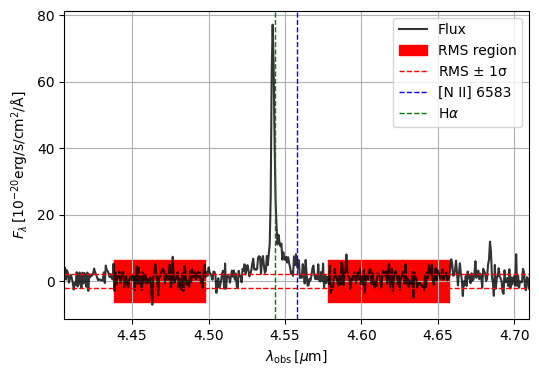

fitting gds-deep-v3_g395m-f290lp_1210_13704.spec.fits


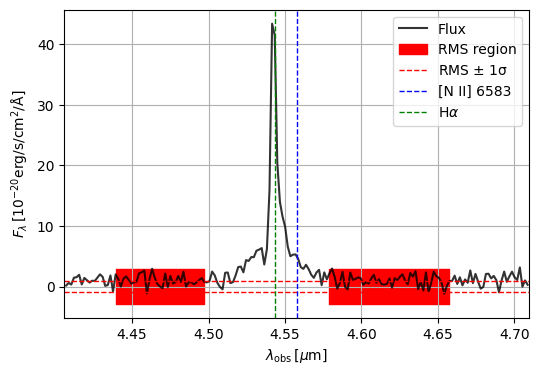

7845
4.13274
fitting jades-gdn09-v3_g235m-f170lp_1181_73488.spec.fits
fitting jades-gdn09-v3_g395h-f290lp_1181_73488.spec.fits


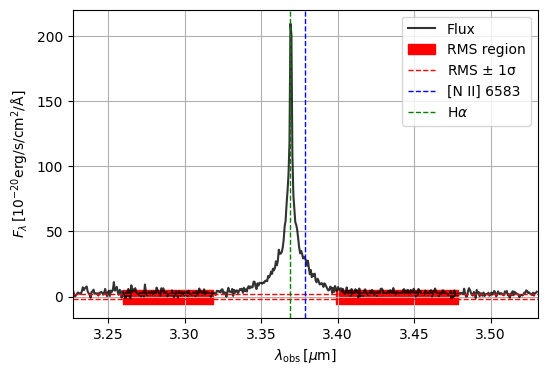

fitting jades-gdn09-v3_g395m-f290lp_1181_73488.spec.fits


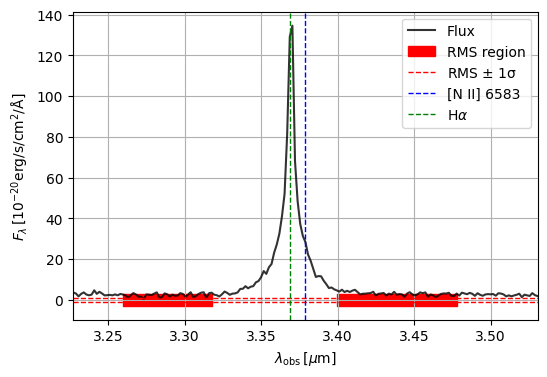

8217
5.2841000000000005
fitting rubies-egs51-nod-v3_g395m-f290lp_4233_926125.spec.fits


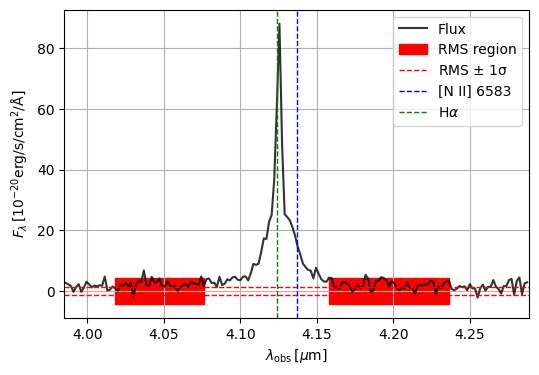

fitting rubies-egs51-v3_g395m-f290lp_4233_926125.spec.fits


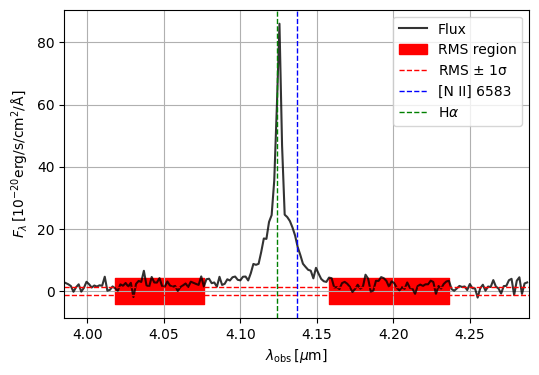

8219
6.7851
fitting rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits


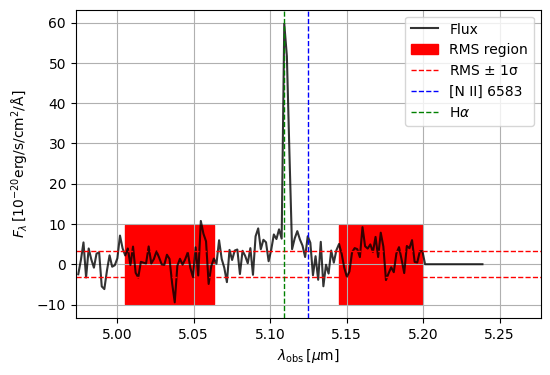

9048
4.542833333333333
fitting rubies-egs52-v3_g395m-f290lp_4233_29489.spec.fits


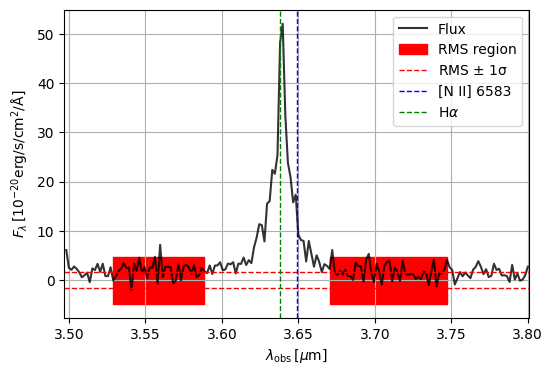

9073
5.680624999999999
fitting rubies-egs52-nod-v3_g395m-f290lp_4233_37124.spec.fits


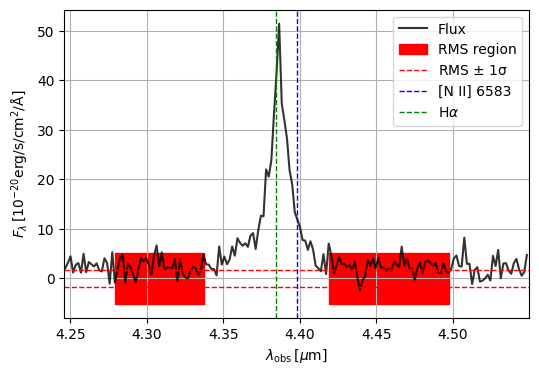

fitting rubies-egs52-v3_g395m-f290lp_4233_37124.spec.fits


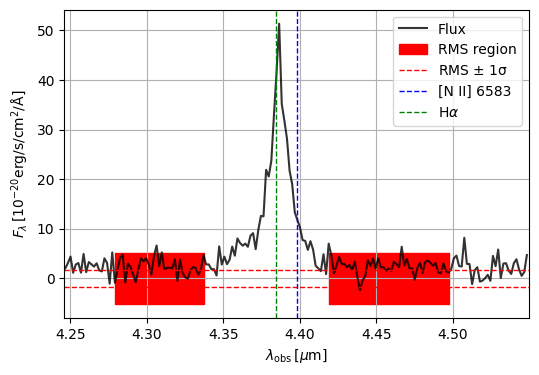

9793
5.0767
fitting rubies-egs61-v3_g395m-f290lp_4233_61496.spec.fits


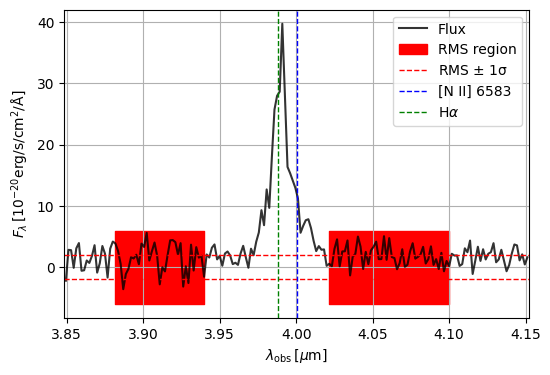

9887
5.103866666666668
fitting rubies-egs61-v3_g395m-f290lp_4233_952625.spec.fits


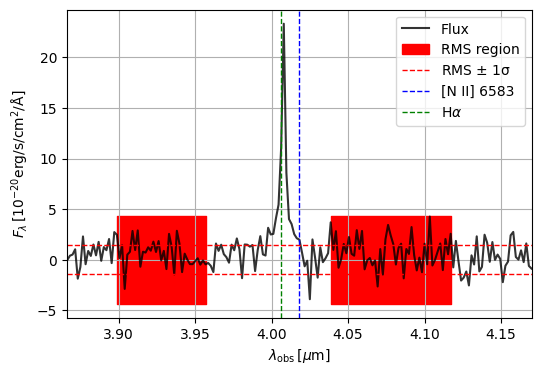

11344
5.4855
fitting rubies-uds41-v3_g395m-f290lp_4233_41571.spec.fits


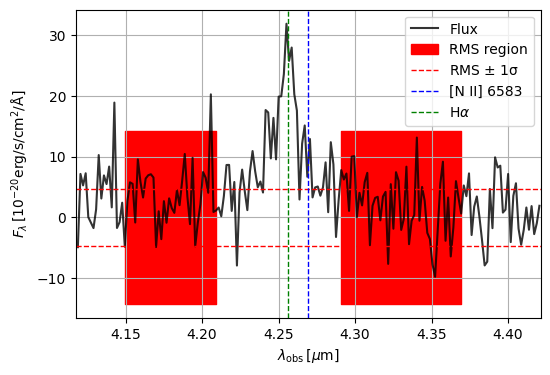

12229
3.8481666666666663
fitting rubies-egs53-v3_g395m-f290lp_4233_37032.spec.fits


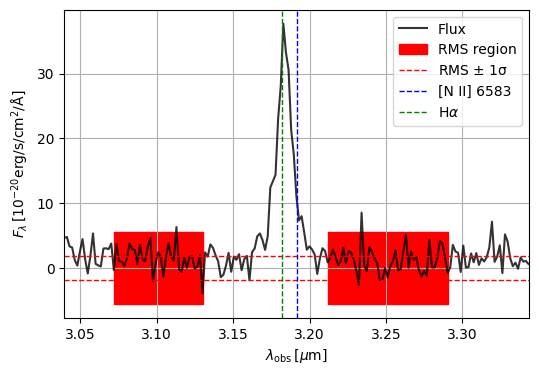

12256
5.272533333333333
fitting rubies-egs53-v3_g395m-f290lp_4233_42046.spec.fits


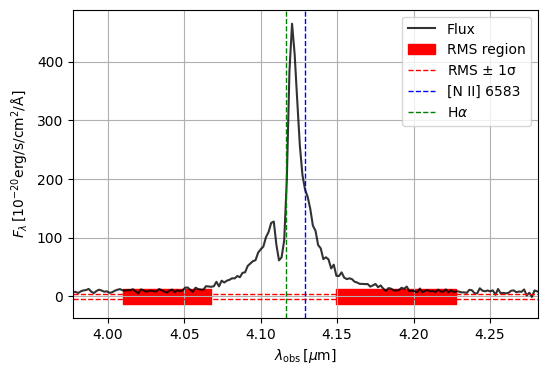

12329
6.6202000000000005
fitting rubies-egs53-v3_g395m-f290lp_4233_53254.spec.fits


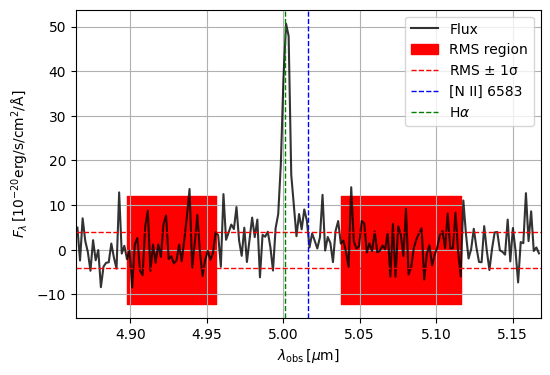

13374
3.962533333333333
fitting rubies-uds42-v3_g395m-f290lp_4233_16053.spec.fits


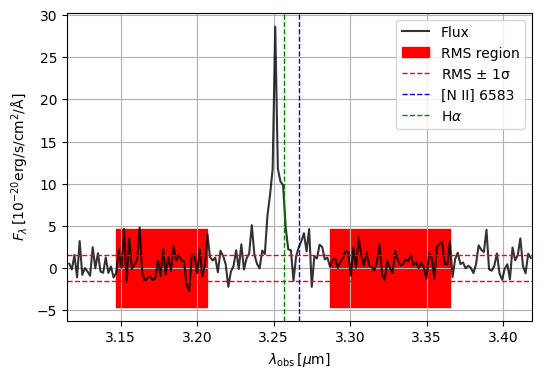

13427
3.6892
fitting rubies-uds42-v3_g395m-f290lp_4233_23438.spec.fits


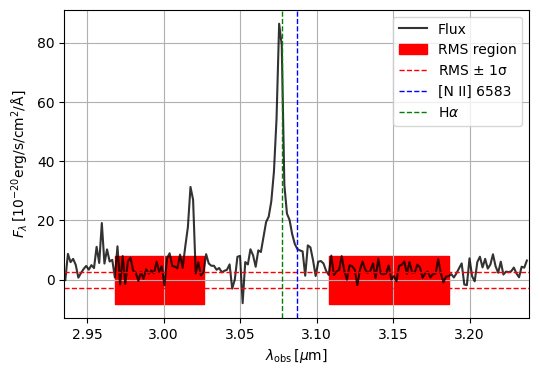

13890
6.471433333333333
fitting rubies-uds42-v3_g395m-f290lp_4233_36171.spec.fits


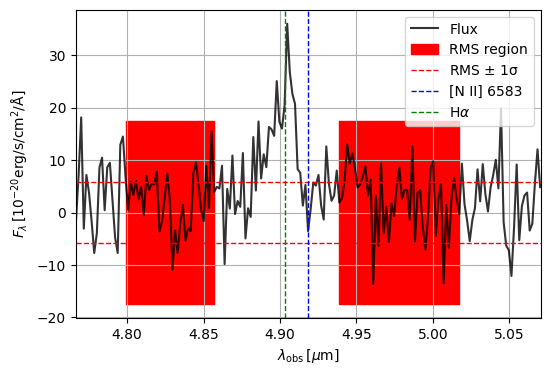

15076
4.13085
fitting rubies-uds1-v3_g395m-f290lp_4233_31747.spec.fits


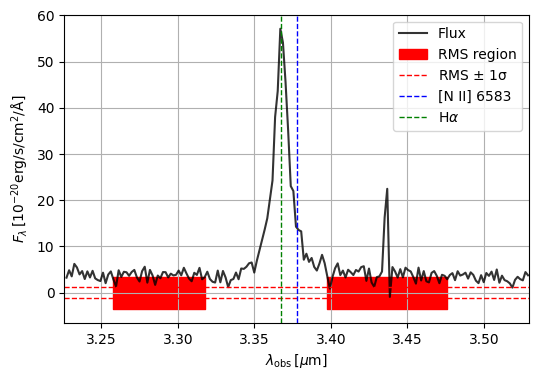

15265
4.848225
fitting jades-gdn-v3_g235m-f170lp_1181_39353.spec.fits
fitting jades-gdn-v3_g395h-f290lp_1181_39353.spec.fits


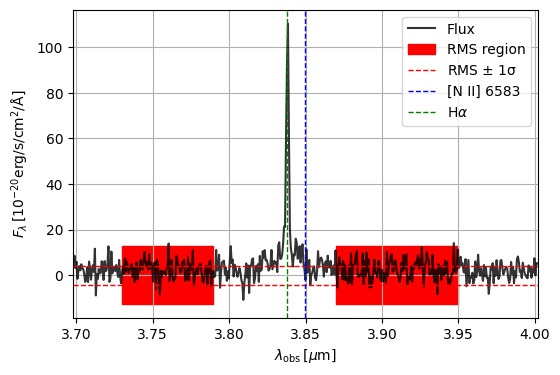

fitting jades-gdn-v3_g395m-f290lp_1181_39353.spec.fits


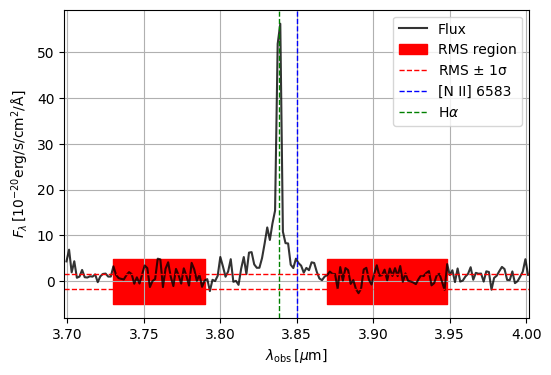

15299
3.429325
fitting jades-gdn-v3_g235m-f170lp_1181_53501.spec.fits


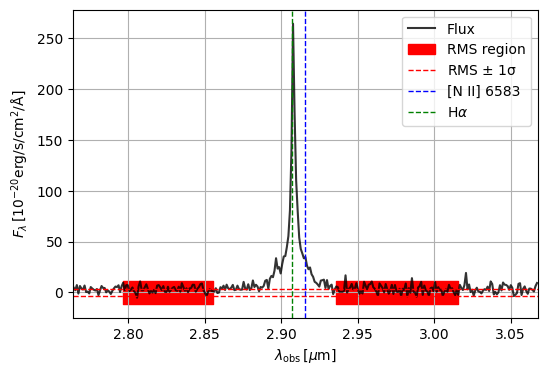

fitting jades-gdn-v3_g395h-f290lp_1181_53501.spec.fits


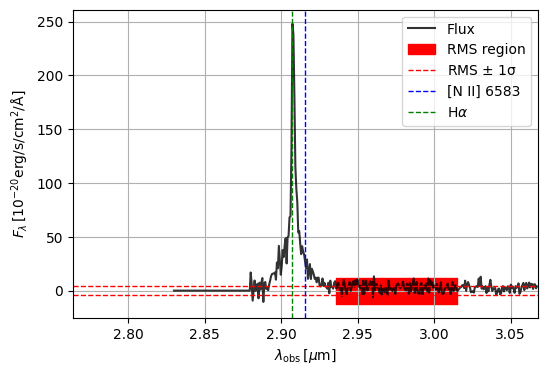

fitting jades-gdn-v3_g395m-f290lp_1181_53501.spec.fits


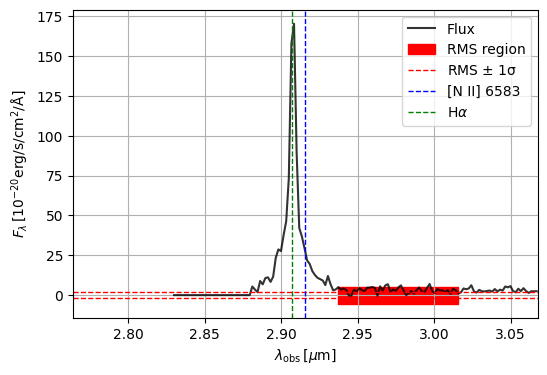

15500
6.069766666666666
fitting rubies-uds1-v3_g395m-f290lp_4233_916674.spec.fits


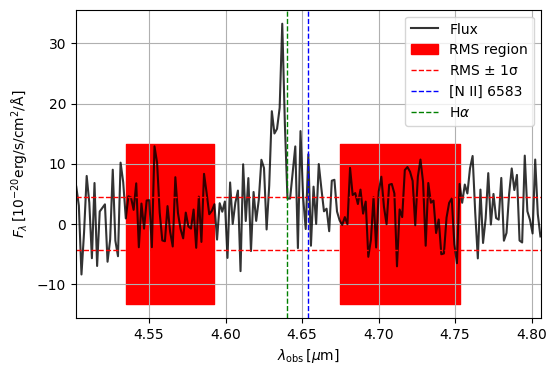

15557
3.7045999999999997
fitting rubies-uds3-v3_g395m-f290lp_4233_42289.spec.fits


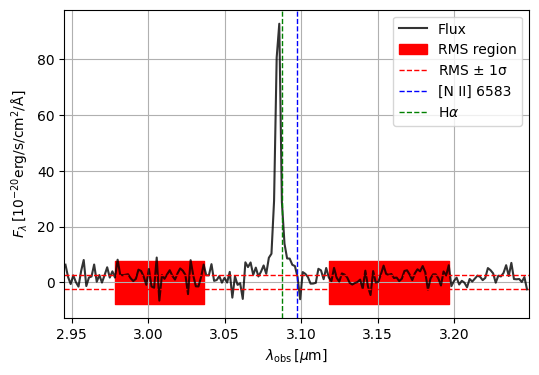

15596
5.6743999999999994
fitting rubies-uds3-v3_g395m-f290lp_4233_47509.spec.fits


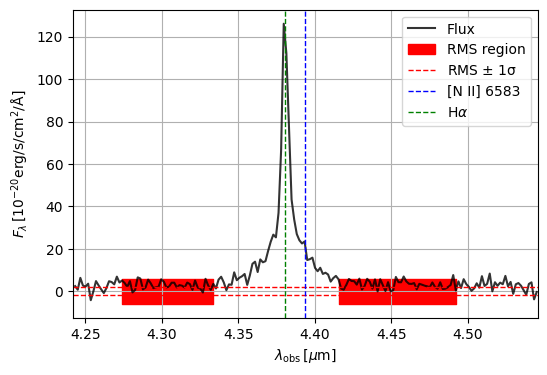

15619
6.1746333333333325
fitting rubies-uds3-v3_g395m-f290lp_4233_50716.spec.fits


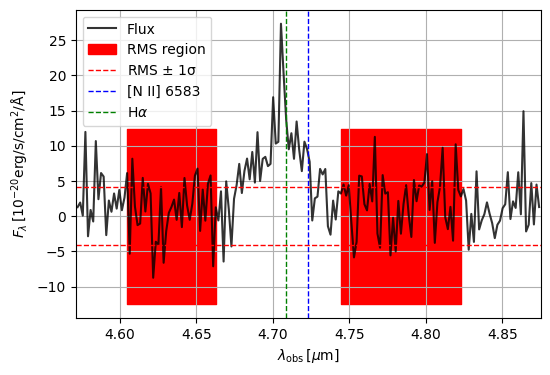

16321
4.9853
fitting rubies-uds43-v3_g395m-f290lp_4233_40800.spec.fits


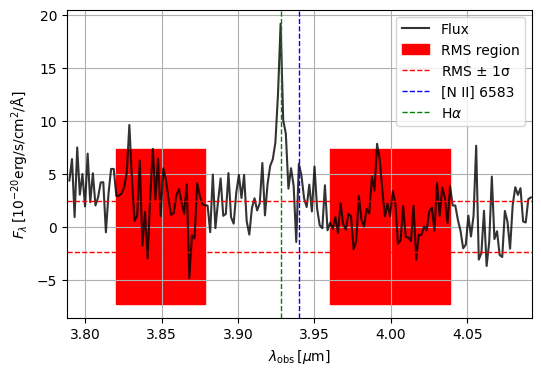

19848
3.5455
fitting rubies-uds31-v3_g395m-f290lp_4233_154183.spec.fits


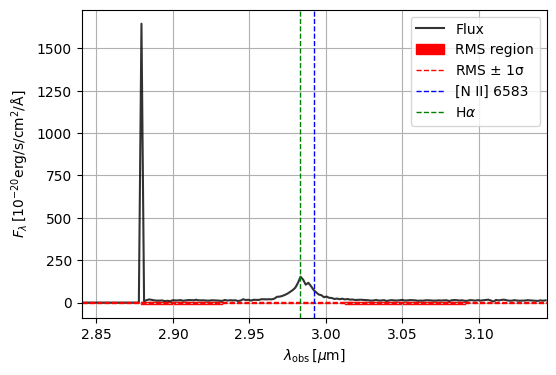

20547
5.27845
fitting rubies-uds33-v3_g395m-f290lp_4233_53692.spec.fits


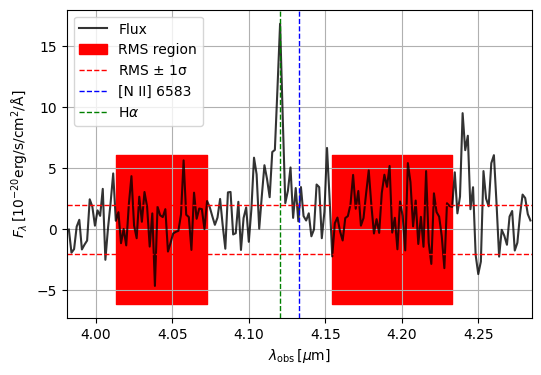

20651
5.5067
fitting gto-wide-uds11-v3_g395h-f290lp_1215_4994.spec.fits


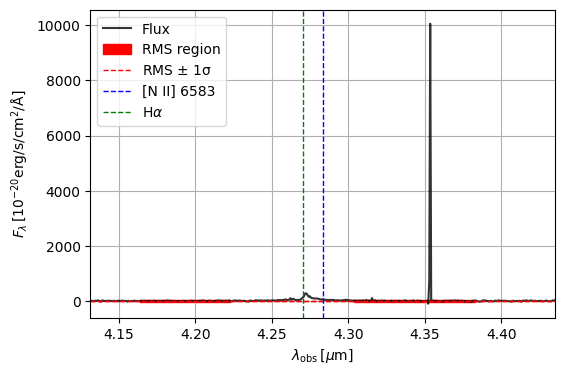

20969
4.688233333333333
fitting gto-wide-uds14-v3_g395h-f290lp_1215_4446.spec.fits


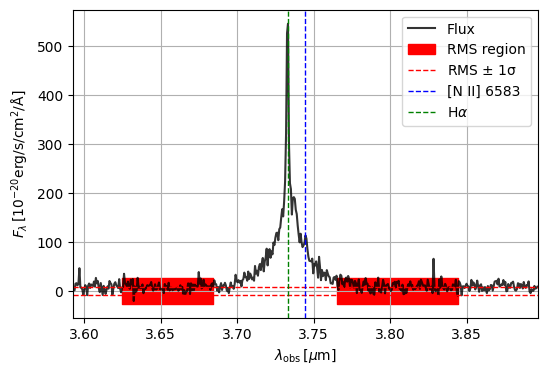

21716
4.96165
fitting rubies-egs62-v3_g395m-f290lp_4233_42232.spec.fits


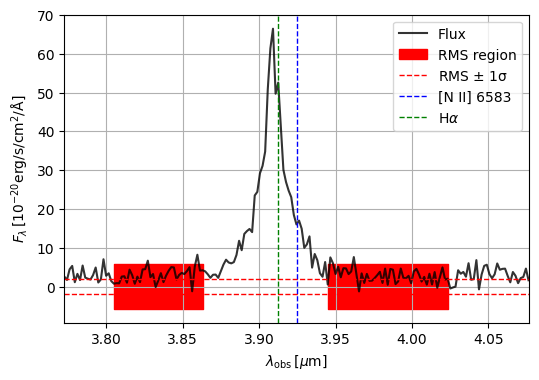

fitting rubies-egs63-v3_g395m-f290lp_4233_42232.spec.fits


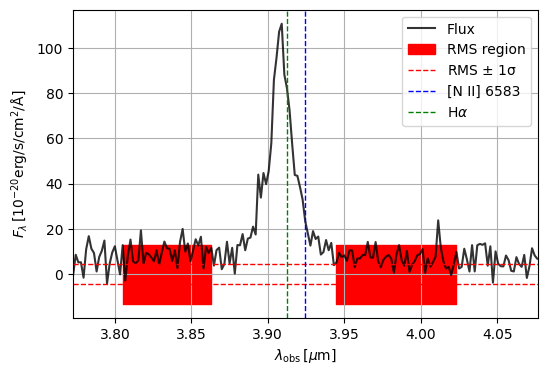

21722
6.684066666666666
fitting rubies-egs63-v3_g395m-f290lp_4233_49140.spec.fits


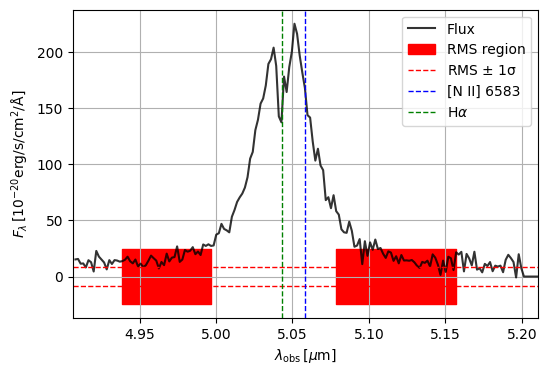

21925
4.222225
fitting rubies-egs63-v3_g395m-f290lp_4233_28812.spec.fits


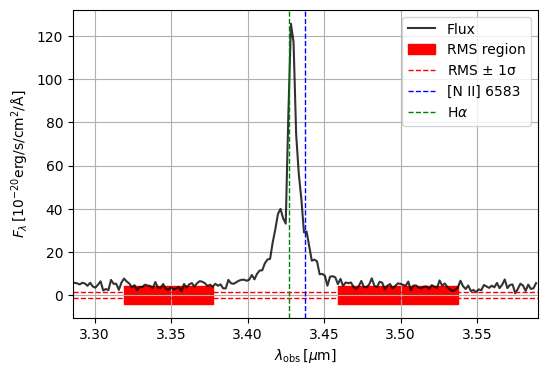

22015
5.127016666666667
fitting rubies-uds41-v3_g395m-f290lp_4233_26611.spec.fits


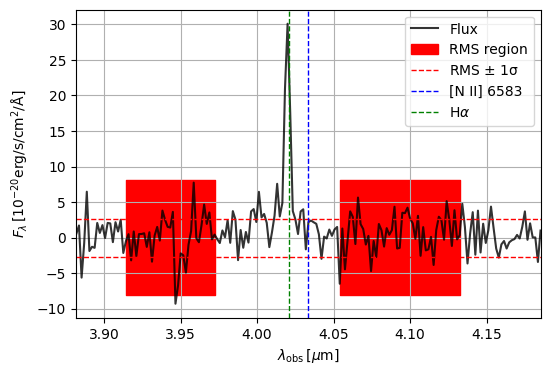

22091
3.472925
fitting gto-wide-uds11-v3_g395h-f290lp_1215_3284.spec.fits


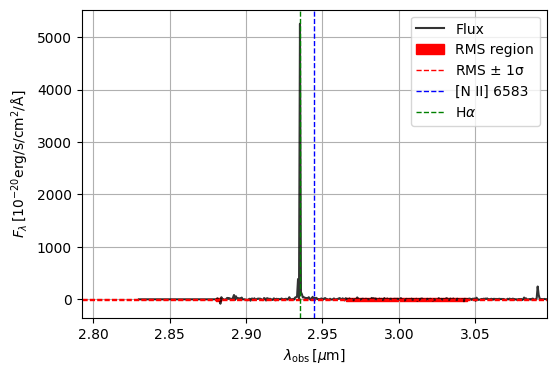

In [6]:
# jades gal NII_upplimt
from astropy.stats import sigma_clip


# line = 'Ha'
# narrowuidlist = [20773, 22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# narrowuidlist = [22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
c = const.c

uidlist = []
rmslist_ = []
zlist = []
# for thisuid in jade_gal['uid']:
for thisuid in lrd_uid_set:
    # if thisuid not in narrowuidlist:
    #      continue
    # if thisuid not in [20547]:
    #      continue

    src = uid == thisuid
    print(thisuid)
    # grating = Grating[src][0]
    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        while True:
            try:
                # print(f'Read {url}')
                key = os.path.basename(url)
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                break
            except:
                print('retry')
                continue
        # print(f'Read {url}')
        # key = os.path.basename(url)
        # sobj[key] = msaexp.spectrum.SpectrumSampler(url)

    for j, k in enumerate(sobj):
        if 'g395m' not in k and 'g395h' not in k and 'g235m' not in k:
        # if 'prism' not in k:
            continue
        if(thisuid == 8219 and j == 2):
            continue
        if(thisuid == 22015 and j == 4):
            continue
        print('fitting', k)
        sp = sobj[k]
        grating = k.split('_')[1] + str(j)

        # reference_wavelength = reference_wavelength
        # obs_wavelength = reference_wavelength * (1 + z)
        # fit_line_id = fit_line_id
        gaussians = []
        component_results = {}
        auto_bounds = False
        max_flux = None
        mask = sp.valid > 0
        w_obs = sp.spec_wobs[mask] / (1 + z) * 10000
        flux = sp.spec['flux'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        flux_err = sp.spec['err'][mask] * sp.spec['to_flam'][mask] * (1 + z) #* 1e-20
        max_flux = np.max(flux)
        # v_obs = (w_obs - reference_wavelength) / reference_wavelength * c.to('km/s').value


        # 计算 [N II] 6583 和 Hα 6563 的观测波长
        lambda_nii_obs = 6583 * (1 + z) / 10000  # 单位：μm
        lambda_ha_obs = 6563 * (1 + z) / 10000   # 单位：μm

        # 示例：自定义选择范围
        rms_intervals = [(-1200, -600), (200,  1000)]  # 单位：Å
        mask_rms = get_rms_mask(sp, lambda_nii_obs, rms_intervals)*mask
        
        # 计算 RMS
        flux_err_rms = sp.spec['flux'][mask_rms] * sp.spec['to_flam'][mask_rms] * (1 + z)
        # rms_nii = np.std(flux_err_rms)
        #sigma clipped rms
        rms_nii = sigma_clip(flux_err_rms, sigma=3, maxiters=3).std()
        if(rms_nii > 0):
            rmslist_.append(rms_nii)
            zlist.append(z)
            uidlist.append(thisuid)
        else:
            rmslist_.append(np.nan)
            zlist.append(z)
            uidlist.append(thisuid)
            continue
        
        # 画图
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # 仅画出感兴趣的区域
        delta_max = 1500
        plot_margin = 20  # 额外的 Å 范围，确保绘图时有足够的可视区域
        zoom_range = delta_max + plot_margin  # 总的缩放范围

        zoom_mask = (sp.spec_wobs > (lambda_nii_obs - zoom_range / 10000)) & \
                    (sp.spec_wobs < (lambda_nii_obs + zoom_range / 10000))

        ax.plot(sp.spec_wobs[zoom_mask], sp.spec['flux'][zoom_mask] * sp.spec['to_flam'][zoom_mask] * (1 + z),
                color='black', alpha=0.8, label="Flux")
        
        # 阴影标注选择的RMS计算区域
        ax.fill_between(sp.spec_wobs, -3*rms_nii, 3*rms_nii, where=mask_rms, color='red', alpha=1, label="RMS region")
        
        # 画 RMS 水平线
        ax.axhline(y=rms_nii, color='r', linestyle='--', lw=1, label=r'RMS $\pm$ 1σ')
        ax.axhline(y=-rms_nii, color='r', linestyle='--', lw=1)
        
        # 标注 [N II] 和 Hα 线位置
        ax.axvline(x=lambda_nii_obs, color='b', linestyle='--', lw=1, label=r'[N II] 6583')
        ax.axvline(x=lambda_ha_obs, color='g', linestyle='--', lw=1, label=r'H$\alpha$')
        
        # 轴标签
        ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')
        ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm^2/\AA}]$')
        plot_margin = 20  # 额外的 Å 范围，确保绘图时有足够的可视区域
        xlim_min = lambda_nii_obs - (delta_max + plot_margin) / 10000
        xlim_max = lambda_nii_obs + (delta_max + plot_margin) / 10000

        ax.set_xlim(xlim_min, xlim_max)
        ax.legend()
        ax.grid()
        
        plt.show()


In [7]:
unique_uidlist = np.unique(uidlist)
unique_rms_list = []
unique_z_list = []
for uid in lrd_uid_set:
    mask = uidlist == uid
    avaival_rms = np.array(rmslist_)[mask]
    avaival_z = np.array(zlist)[mask]
    if(np.isnan(avaival_rms).all()):
        unique_rms_list.append(np.nan)
        unique_z_list.append(np.nan)
        continue
    else:
        unique_rms_list.append(np.nanmin(avaival_rms))
        unique_z_list.append(np.nanmean(avaival_z))

unique_uidlist = np.array(unique_uidlist)

rmslist = np.array(unique_rms_list)/1e20
z = np.array(unique_z_list)
reference_wavelength = 6583*u.AA


In [ ]:
luminosity_list = []

for index in range(len(selectedlrd_cat)):
    unilist_arg = np.where(unique_uidlist == selectedlrd_cat['source_id'][index])[0][0]
    width_v = np.array([selectedlrd_cat['Ha_FWHM_narrow'][index]])/2.355

    peak = rmslist[unilist_arg]*5
    width_AA = width_v * reference_wavelength / const.c.to('km/s').value
    # width_err_AA = width_v_err * reference_wavelength / const.c.to('km/s').value
    # Calculate flux and flux error
    flux = peak * width_AA * np.sqrt(2 * np.pi)

    # calculate luminosity
    z = unique_z_list[unilist_arg]
    lumdis = cosmo.luminosity_distance(z)
    luminosity = flux * 4 * np.pi * lumdis.to('cm').value ** 2
    luminosity_list.append(luminosity.value[0])

In [15]:
selectedlrd_cat['L_NII_uplim'] = luminosity_list
selectedlrd_cat.write('/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf_z2/LRD_spectral_catalog_withNIIuplim.csv')

In [16]:
selectedlrd_cat

<Table length=32>
source_id    grating    BIC_Ha2 ... Hb_EW_err       L_NII_uplim      
  int64       str13     float64 ...  float64          float64        
--------- ------------- ------- ... ---------- ----------------------
     7316 g395h-f290lp2 175.468 ...       1.02  6.503020128497247e+40
     7845 g395h-f290lp2  460.55 ...        1.0 3.8377621748199254e+40
     8217 g395m-f290lp0  24.662 ...       1.03 1.2122771870878974e+41
     8219 g395m-f290lp0  34.011 ...       0.97 3.9820460242258016e+41
     9048 g395m-f290lp1  16.647 ...         --  1.154897619626397e+41
     9073 g395m-f290lp0  38.421 ...         -- 1.6108020691541825e+41
     9793 g395m-f290lp1  35.878 ...       0.94  1.229674297605113e+41
     9887 g395m-f290lp1   3.332 ...       0.12  8.785811477586754e+40
    11344 g395m-f290lp0  28.936 ...        0.3  8.790552824884472e+41
    12229 g395m-f290lp1  16.658 ...         -- 1.9931571071227636e+41
      ...           ...     ... ...        ...                    ...
    16321 g395m-f290lp1  31.124 ...     174.56 2.6733013573615872e+41
    19848 g395m-f290lp1  79.041 ...         -- 2.9597570929117704e+41
    20547 g395m-f290lp0  99.671 ...       0.91 1.6816261309310302e+41
    20651 g395h-f290lp0 142.781 ...       0.24 1.1488405887114817e+42
    20969 g395h-f290lp1 125.498 ...         --  3.283028487747488e+41
    21716 g395m-f290lp1  36.076 ...       0.23 3.5179874763663126e+41
    21722 g395m-f290lp1 258.551 ...       0.22 1.1372865914442579e+42
    21925 g395m-f290lp2  85.587 ...         -- 1.0515375994936837e+41
    22015 g395m-f290lp1  28.352 ... 22033444.1 2.4202097675487726e+41
    22091 g395h-f290lp2  87.141 ...         --  4.777211390638504e+40